In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.decomposition import PCA
import optuna
from optuna.samplers import TPESampler
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import joblib

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

C:\Users\offic\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ----------------------------------------
# 1. Data Preparation and Preprocessing
# ----------------------------------------

# Paths
dataset_path = r"C:\Users\offic\OneDrive\Masaüstü\datasets\ml-latest-small"

# Load data
ratings = pd.read_csv(f"{dataset_path}\\ratings.csv")
movies = pd.read_csv(f"{dataset_path}\\movies.csv")
tags = pd.read_csv(f"{dataset_path}\\tags.csv")

# Verify data integrity
assert 'movieId' in movies.columns and 'genres' in movies.columns, "movies.csv missing required columns."
assert 'userId' in ratings.columns and 'movieId' in ratings.columns and 'rating' in ratings.columns, "ratings.csv missing required columns."

# Feature Engineering

## 1.1. Encode Genres as Multi-Hot Vectors
# Extract unique genres
genres = set()
for genre_list in movies['genres'].str.split('|'):
    genres.update(genre_list)
genres.discard('(no genres listed)')
genre_list = sorted(list(genres))
num_genres = len(genre_list)

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=genre_list)
genre_features = mlb.fit_transform(movies['genres'].str.split('|'))

# Convert to torch tensor
genre_tensor = torch.tensor(genre_features, dtype=torch.float)

## 1.2. Process Tags
# Transition from Multi-Hot Encoding to Tag Indices

# Extract unique tags and create a mapping
unique_tags = tags['tag'].unique()
tag_to_idx = {tag: idx for idx, tag in enumerate(unique_tags)}
num_tags = len(tag_to_idx)

# Reserve a special index for padding
padding_idx = num_tags  # This will be used for padding

# For each movie, create a list of tag indices
tags_grouped = tags.groupby('movieId')['tag'].apply(list).reset_index()

# Merge tags back to movies
movies = movies.merge(tags_grouped, on='movieId', how='left')
movies['tag'] = movies['tag'].apply(lambda x: x if isinstance(x, list) else [])

# Convert tag lists to lists of indices
movies['tag_indices'] = movies['tag'].apply(
    lambda x: [tag_to_idx[tag] for tag in x if tag in tag_to_idx]
)

# Determine maximum number of tags per movie for padding
max_tags = movies['tag_indices'].apply(len).max()

# Pad tag index lists with the padding index
movies['tag_indices_padded'] = movies['tag_indices'].apply(
    lambda x: x + [padding_idx] * (max_tags - len(x))
)

# Convert to a 2D numpy array
tag_indices_array = np.vstack(movies['tag_indices_padded'].values)

# Convert to torch tensor
tag_indices_tensor = torch.tensor(tag_indices_array, dtype=torch.long)

# Verify that all tag indices are within [0, num_tags]
assert tag_indices_tensor.max() <= padding_idx, "Tag indices exceed the padding index."
assert tag_indices_tensor.min() >= 0, "Tag indices contain negative values."

## 1.3. Encode Users and Movies
# Unique users and movies
user_ids = ratings['userId'].unique()
movie_ids = ratings['movieId'].unique()

user_mapping = {id: idx for idx, id in enumerate(user_ids)}
movie_mapping = {id: idx + len(user_mapping) for idx, id in enumerate(movie_ids)}

ratings['user_idx'] = ratings['userId'].map(user_mapping)
ratings['movie_idx'] = ratings['movieId'].map(movie_mapping)
movies = movies[movies['movieId'].isin(movie_ids)].reset_index(drop=True)
movie_idx_mapping = {id: idx for idx, id in enumerate(movies['movieId'])}

# Node Features

## 1.4. User Features
# Since no user demographics are available, we'll use learnable embeddings
num_users = len(user_mapping)
user_embedding_dim = 128  # Hyperparameter

# Initialize random embeddings for users
user_random = torch.randn(num_users, user_embedding_dim)

## 1.5. Movie Features
# Combine genre and tag features with random embeddings
num_movies = len(movie_mapping)
movie_embedding_dim = 128  # Hyperparameter

# Random embeddings for movies
movie_random = torch.randn(num_movies, movie_embedding_dim)

# Concatenate genre features
movie_content = genre_tensor[:num_movies]  # Shape: (num_movies, num_genres)

# Normalize content features
scaler = StandardScaler()
movie_content_np = movie_content.numpy()
movie_content_scaled = scaler.fit_transform(movie_content_np)
movie_content_scaled = torch.tensor(movie_content_scaled, dtype=torch.float)

# Dimensionality Reduction using PCA to manage high-dimensional genre features
# Since num_genres=19, set n_components to <=19 (e.g., 10)
pca = PCA(n_components=10)
movie_content_reduced = torch.tensor(pca.fit_transform(movie_content_scaled.numpy()), dtype=torch.float)

# Final movie features: concatenate with movie_random and content_reduced
movie_features = torch.cat([movie_random, movie_content_reduced], dim=1)

## 1.6. Combine User and Movie Features
# To match feature dimensions, pad user_features with zeros
user_padding = torch.zeros(num_users, movie_content_reduced.size(1))
user_features = torch.cat([user_random, user_padding], dim=1)

# Combine user and movie features
x = torch.cat([user_features, movie_features], dim=0)

## 1.7. Normalize Node Features
scaler_nodes = StandardScaler()
x_np = x.numpy()
x_scaled = scaler_nodes.fit_transform(x_np)
x = torch.tensor(x_scaled, dtype=torch.float)


In [3]:
# ----------------------------------------
# 2. Graph Construction
# ----------------------------------------

# Edge Index
edge_index = torch.tensor(
    [ratings['user_idx'].values, ratings['movie_idx'].values], dtype=torch.long
)

# Edge Weights: Normalized Ratings
edge_weight = torch.tensor(ratings['rating'].values, dtype=torch.float)
edge_weight = (edge_weight - edge_weight.min()) / (edge_weight.max() - edge_weight.min())

# Create PyTorch Geometric Data Object
data = Data(x=x, edge_index=edge_index)

In [4]:
# ----------------------------------------
# 3. Data Splitting
# ----------------------------------------

# Total number of edges
num_edges = edge_index.size(1)
all_edge_indices = torch.arange(num_edges)

# Split into Train (80%), Validation (10%), Test (10%)
train_val_idx, test_idx = train_test_split(all_edge_indices.numpy(), test_size=0.1, random_state=42)
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.1111, random_state=42)

# Convert back to torch tensors
train_idx = torch.tensor(train_idx, dtype=torch.long)
val_idx = torch.tensor(val_idx, dtype=torch.long)
test_idx = torch.tensor(test_idx, dtype=torch.long)

In [5]:
# ----------------------------------------
# 4. Model Definition
# ----------------------------------------

class GNN_VAE(nn.Module):
    def __init__(self, input_dim, hidden_channels, latent_dim, decoder_channels, num_tags, tag_embedding_dim=50, dropout=0.5):
        super(GNN_VAE, self).__init__()
        # Encoder
        self.conv1 = GATConv(input_dim, hidden_channels, heads=2, concat=False)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.dropout1 = nn.Dropout(p=dropout)
        self.conv2 = GCNConv(hidden_channels, latent_dim)
        self.bn2 = nn.BatchNorm1d(latent_dim)
        self.dropout2 = nn.Dropout(p=dropout)
        self.mu_layer = nn.Linear(latent_dim, latent_dim)
        self.logvar_layer = nn.Linear(latent_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim * 2, decoder_channels),  # Adjusted input dimension
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(decoder_channels, 1)
        )

        # Residual Connection 
        self.residual = nn.Linear(latent_dim, latent_dim)  

        # Tag Embedding Layer
        self.tag_embedding = nn.Embedding(num_tags + 1, tag_embedding_dim, padding_idx=num_tags)
        self.tag_dim_reduction = nn.Linear(tag_embedding_dim, 50)

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x) 
        x = self.dropout1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x) 
        x = self.dropout2(x)
        mu = self.mu_layer(x)
        logvar = self.logvar_layer(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, edge_index):
        row, col = edge_index
        # Residual Connection
        z_row = self.residual(z[row]) 
        z_col = self.residual(z[col]) 
        edge_embeddings = torch.cat([z_row, z_col], dim=1)  
        return self.decoder(edge_embeddings).squeeze()

    def forward(self, x, edge_index):
        mu, logvar = self.encode(x, edge_index)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, edge_index)
        return recon, mu, logvar

    # Function to incorporate Tag Embeddings 
    def incorporate_tags(self, tag_indices):
        """
        tag_indices: Tensor of shape (num_nodes, max_tags)
        """
        # Get tag embeddings
        tag_embedded = self.tag_embedding(tag_indices) 
        
        # Handle padding: set embeddings of padding indices to zero
        mask = (tag_indices != self.tag_embedding.padding_idx).unsqueeze(-1).float()  
        tag_embedded = tag_embedded * mask 
        
        # Aggregate tag embeddings (mean over tags)
        tag_sum = tag_embedded.sum(dim=1)  
        tag_count = mask.sum(dim=1)         
        tag_mean = tag_sum / (tag_count + 1e-8)  
        
        # Dimensionality Reduction
        tag_reduced = self.tag_dim_reduction(tag_mean)  
        return tag_reduced

In [6]:
# ----------------------------------------
# 5. Loss Function and Evaluation Metrics
# ----------------------------------------

def vae_loss(recon, edge_weight, mu, logvar):
    recon_loss = F.mse_loss(recon, edge_weight, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 0.001 * kl_div  # Weighted KL-divergence

def precision_at_k(pred_scores, true_labels, k=10):
    top_k = torch.topk(pred_scores, k=k, largest=True).indices
    top_k_labels = true_labels[top_k]
    return top_k_labels.sum().item() / k

def ndcg_at_k(pred_scores, true_labels, k=10):
    _, indices = torch.topk(pred_scores, k=k, largest=True)
    dcg = (true_labels[indices] / torch.log2(torch.arange(2, k + 2).float())).sum().item()
    ideal = (torch.sort(true_labels, descending=True).values[:k] / torch.log2(torch.arange(2, k + 2).float())).sum().item()
    return dcg / ideal if ideal > 0 else 0.0

In [7]:
# ----------------------------------------
# 6. Training and Evaluation Functions 
# ----------------------------------------

def train_model(model, data, train_idx, val_idx, edge_weight, tag_indices, optimizer, scheduler, epochs=50, early_stopping_patience=7):
    history = {'train_loss': [], 'val_loss': [], 'precision': [], 'ndcg': []}
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        # Incorporate tag embeddings
        tag_features = model.incorporate_tags(tag_indices) 

        recon, mu, logvar = model(data.x, data.edge_index[:, train_idx])
        loss = vae_loss(recon, edge_weight[train_idx], mu, logvar)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            recon_val, _, _ = model(data.x, data.edge_index[:, val_idx])
            val_loss = F.mse_loss(recon_val, edge_weight[val_idx], reduction='mean')

            # Calculate additional metrics
            precision = precision_at_k(recon_val, edge_weight[val_idx], k=10)
            ndcg = ndcg_at_k(recon_val, edge_weight[val_idx], k=10)

        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        history['precision'].append(precision)
        history['ndcg'].append(ndcg)

        # Scheduler step 
        scheduler.step()

        print(f"Epoch {epoch:02d}/{epochs}, "
              f"Train Loss: {loss.item():.4f}, "
              f"Val Loss: {val_loss.item():.4f}, "
              f"Precision@10: {precision:.4f}, "
              f"NDCG@10: {ndcg:.4f}")

        # Early Stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    # Load best model state
    model.load_state_dict(best_model_state)
    return history

def evaluate_model(model, data, test_idx, edge_weight, tag_indices):
    model.eval()
    with torch.no_grad():
        # Incorporate tag embeddings 
        tag_features = model.incorporate_tags(tag_indices)

        recon_test, _, _ = model(data.x, data.edge_index[:, test_idx])
        test_loss = F.mse_loss(recon_test, edge_weight[test_idx], reduction='mean')
        precision = precision_at_k(recon_test, edge_weight[test_idx], k=10)
        ndcg = ndcg_at_k(recon_test, edge_weight[test_idx], k=10)
    print(f"Test Loss: {test_loss.item():.4f}, Precision@10: {precision:.4f}, NDCG@10: {ndcg:.4f}")
    return test_loss.item(), precision, ndcg

In [8]:
# ----------------------------------------
# 7. Hyperparameter Optimization with Optuna 
# ----------------------------------------

def objective(trial):
    # Hyperparameter suggestions
    hidden_channels = trial.suggest_int('hidden_channels', 64, 256)
    latent_dim = trial.suggest_int('latent_dim', 32, 128)
    decoder_channels = trial.suggest_int('decoder_channels', 64, 256)
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)

    # Model Initialization
    model = GNN_VAE(
        input_dim=x.size(1), 
        hidden_channels=hidden_channels, 
        latent_dim=latent_dim, 
        decoder_channels=decoder_channels,
        num_tags=num_tags,
        dropout=dropout
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)  # UPDATED

    # Training
    history = train_model(
        model, data, train_idx, val_idx, edge_weight, tag_indices_tensor,  # UPDATED: pass tag_indices_tensor
        optimizer, scheduler, epochs=50, early_stopping_patience=7
    )

    # Validation Loss
    final_val_loss = history['val_loss'][-1]
    return final_val_loss

In [9]:
# ----------------------------------------
# 8. Running Hyperparameter Optimization
# ----------------------------------------

# Define Optuna study with TPE sampler for efficiency
sampler = TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)

# Optimize
print("Starting Hyperparameter Optimization...")
study.optimize(objective, n_trials=50, timeout=None)

# Display Best Trial
best_trial = study.best_trial
print(f"\nBest Trial {best_trial.number} with Val Loss: {best_trial.value:.6f}")
print(f"Parameters: {best_trial.params}")

[I 2025-01-07 14:50:32,399] A new study created in memory with name: no-name-6087d515-f516-4acb-b268-35b8f1ad6dd7


Starting Hyperparameter Optimization...
Epoch 01/50, Train Loss: 0.5099, Val Loss: 0.5016, Precision@10: 0.7000, NDCG@10: 0.6633
Epoch 02/50, Train Loss: 0.4378, Val Loss: 0.4679, Precision@10: 0.7889, NDCG@10: 0.8036
Epoch 03/50, Train Loss: 0.3861, Val Loss: 0.4534, Precision@10: 0.6778, NDCG@10: 0.5903
Epoch 04/50, Train Loss: 0.3265, Val Loss: 0.4425, Precision@10: 0.7111, NDCG@10: 0.7207
Epoch 05/50, Train Loss: 0.2843, Val Loss: 0.4324, Precision@10: 0.7889, NDCG@10: 0.7927
Epoch 06/50, Train Loss: 0.2638, Val Loss: 0.4011, Precision@10: 0.7667, NDCG@10: 0.7495
Epoch 07/50, Train Loss: 0.2373, Val Loss: 0.3933, Precision@10: 0.8556, NDCG@10: 0.8705
Epoch 08/50, Train Loss: 0.2284, Val Loss: 0.3845, Precision@10: 0.6444, NDCG@10: 0.6417
Epoch 09/50, Train Loss: 0.2241, Val Loss: 0.3956, Precision@10: 0.6889, NDCG@10: 0.7535
Epoch 10/50, Train Loss: 0.2207, Val Loss: 0.3691, Precision@10: 0.8556, NDCG@10: 0.8797
Epoch 11/50, Train Loss: 0.2149, Val Loss: 0.3631, Precision@10: 0.611

[I 2025-01-07 14:51:33,345] Trial 0 finished with value: 0.20191669464111328 and parameters: {'hidden_channels': 136, 'latent_dim': 124, 'decoder_channels': 205, 'dropout': 0.379597545259111, 'lr': 0.0002051338263087451, 'weight_decay': 2.9375384576328313e-06}. Best is trial 0 with value: 0.20191669464111328.


Epoch 42/50, Train Loss: 0.1269, Val Loss: 0.2019, Precision@10: 0.7333, NDCG@10: 0.7420
Early stopping triggered.
Epoch 01/50, Train Loss: 0.7209, Val Loss: 0.6637, Precision@10: 0.6556, NDCG@10: 0.6668
Epoch 02/50, Train Loss: 0.6944, Val Loss: 0.6479, Precision@10: 0.8444, NDCG@10: 0.8796
Epoch 03/50, Train Loss: 0.6870, Val Loss: 0.6167, Precision@10: 0.5556, NDCG@10: 0.5448
Epoch 04/50, Train Loss: 0.6228, Val Loss: 0.5887, Precision@10: 0.6889, NDCG@10: 0.6989
Epoch 05/50, Train Loss: 0.5880, Val Loss: 0.5942, Precision@10: 0.5556, NDCG@10: 0.5612
Epoch 06/50, Train Loss: 0.5851, Val Loss: 0.5819, Precision@10: 0.5333, NDCG@10: 0.4870
Epoch 07/50, Train Loss: 0.5402, Val Loss: 0.5724, Precision@10: 0.6333, NDCG@10: 0.6139
Epoch 08/50, Train Loss: 0.5272, Val Loss: 0.5593, Precision@10: 0.7111, NDCG@10: 0.7092
Epoch 09/50, Train Loss: 0.5012, Val Loss: 0.5520, Precision@10: 0.6667, NDCG@10: 0.7056
Epoch 10/50, Train Loss: 0.4667, Val Loss: 0.5324, Precision@10: 0.7000, NDCG@10: 0.

[I 2025-01-07 14:52:24,169] Trial 1 finished with value: 0.39468249678611755 and parameters: {'hidden_channels': 75, 'latent_dim': 116, 'decoder_channels': 180, 'dropout': 0.4124217733388137, 'lr': 0.00010994335574766199, 'weight_decay': 0.0008123245085588687}. Best is trial 0 with value: 0.20191669464111328.


Epoch 50/50, Train Loss: 0.2493, Val Loss: 0.3947, Precision@10: 0.8778, NDCG@10: 0.8594
Epoch 01/50, Train Loss: 0.4467, Val Loss: 0.4425, Precision@10: 0.7333, NDCG@10: 0.7665
Epoch 02/50, Train Loss: 0.3938, Val Loss: 0.4238, Precision@10: 0.7667, NDCG@10: 0.7150
Epoch 03/50, Train Loss: 0.3288, Val Loss: 0.4167, Precision@10: 0.6889, NDCG@10: 0.5745
Epoch 04/50, Train Loss: 0.2907, Val Loss: 0.3770, Precision@10: 0.7222, NDCG@10: 0.7447
Epoch 05/50, Train Loss: 0.2511, Val Loss: 0.3765, Precision@10: 0.7556, NDCG@10: 0.7287
Epoch 06/50, Train Loss: 0.2249, Val Loss: 0.3644, Precision@10: 0.8222, NDCG@10: 0.7994
Epoch 07/50, Train Loss: 0.2039, Val Loss: 0.3395, Precision@10: 0.7444, NDCG@10: 0.8011
Epoch 08/50, Train Loss: 0.1972, Val Loss: 0.3373, Precision@10: 0.8444, NDCG@10: 0.8448
Epoch 09/50, Train Loss: 0.1873, Val Loss: 0.3165, Precision@10: 0.7333, NDCG@10: 0.6974
Epoch 10/50, Train Loss: 0.1809, Val Loss: 0.3124, Precision@10: 0.7444, NDCG@10: 0.8019
Epoch 11/50, Train Lo

[I 2025-01-07 14:53:01,209] Trial 2 finished with value: 0.15474039316177368 and parameters: {'hidden_channels': 224, 'latent_dim': 52, 'decoder_channels': 99, 'dropout': 0.2550213529560302, 'lr': 0.0004059611610484307, 'weight_decay': 3.752055855124284e-05}. Best is trial 2 with value: 0.15474039316177368.


Epoch 50/50, Train Loss: 0.1067, Val Loss: 0.1547, Precision@10: 0.7000, NDCG@10: 0.6507
Epoch 01/50, Train Loss: 0.5660, Val Loss: 0.5356, Precision@10: 0.4667, NDCG@10: 0.5080
Epoch 02/50, Train Loss: 0.4928, Val Loss: 0.5169, Precision@10: 0.6222, NDCG@10: 0.5741
Epoch 03/50, Train Loss: 0.4189, Val Loss: 0.4736, Precision@10: 0.6444, NDCG@10: 0.6153
Epoch 04/50, Train Loss: 0.3457, Val Loss: 0.4528, Precision@10: 0.6556, NDCG@10: 0.6619
Epoch 05/50, Train Loss: 0.2993, Val Loss: 0.4256, Precision@10: 0.7667, NDCG@10: 0.7825
Epoch 06/50, Train Loss: 0.2511, Val Loss: 0.4054, Precision@10: 0.4667, NDCG@10: 0.4410
Epoch 07/50, Train Loss: 0.2224, Val Loss: 0.3864, Precision@10: 0.6889, NDCG@10: 0.7110
Epoch 08/50, Train Loss: 0.2043, Val Loss: 0.3721, Precision@10: 0.5889, NDCG@10: 0.5996
Epoch 09/50, Train Loss: 0.2092, Val Loss: 0.3553, Precision@10: 0.6556, NDCG@10: 0.7050
Epoch 10/50, Train Loss: 0.1944, Val Loss: 0.3267, Precision@10: 0.8556, NDCG@10: 0.8548
Epoch 11/50, Train Lo

[I 2025-01-07 14:53:37,487] Trial 3 finished with value: 0.13805168867111206 and parameters: {'hidden_channels': 147, 'latent_dim': 60, 'decoder_channels': 182, 'dropout': 0.24184815819561256, 'lr': 0.0003839629299804173, 'weight_decay': 1.2562773503807034e-05}. Best is trial 3 with value: 0.13805168867111206.


Epoch 49/50, Train Loss: 0.0945, Val Loss: 0.1381, Precision@10: 0.7000, NDCG@10: 0.7728
Early stopping triggered.
Epoch 01/50, Train Loss: 0.4153, Val Loss: 0.3103, Precision@10: 0.7889, NDCG@10: 0.7955
Epoch 02/50, Train Loss: 0.1877, Val Loss: 0.2424, Precision@10: 0.8556, NDCG@10: 0.8506
Epoch 03/50, Train Loss: 0.2116, Val Loss: 0.2283, Precision@10: 0.6111, NDCG@10: 0.6310
Epoch 04/50, Train Loss: 0.1446, Val Loss: 0.2174, Precision@10: 0.7556, NDCG@10: 0.7747
Epoch 05/50, Train Loss: 0.1217, Val Loss: 0.1896, Precision@10: 0.7667, NDCG@10: 0.7500
Epoch 06/50, Train Loss: 0.1228, Val Loss: 0.1727, Precision@10: 0.8333, NDCG@10: 0.8587
Epoch 07/50, Train Loss: 0.1104, Val Loss: 0.1497, Precision@10: 0.7556, NDCG@10: 0.7244
Epoch 08/50, Train Loss: 0.1009, Val Loss: 0.1239, Precision@10: 0.4667, NDCG@10: 0.4222
Epoch 09/50, Train Loss: 0.0975, Val Loss: 0.1002, Precision@10: 0.6333, NDCG@10: 0.5885
Epoch 10/50, Train Loss: 0.0954, Val Loss: 0.0956, Precision@10: 0.8222, NDCG@10: 0.

[I 2025-01-07 14:54:02,923] Trial 4 finished with value: 0.07550909370183945 and parameters: {'hidden_channels': 152, 'latent_dim': 108, 'decoder_channels': 102, 'dropout': 0.3542703315240835, 'lr': 0.0015304852121831463, 'weight_decay': 1.3783237455007196e-06}. Best is trial 4 with value: 0.07550909370183945.


Epoch 29/50, Train Loss: 0.0787, Val Loss: 0.0755, Precision@10: 0.6889, NDCG@10: 0.6859
Early stopping triggered.
Epoch 01/50, Train Loss: 0.6868, Val Loss: 0.2137, Precision@10: 0.8000, NDCG@10: 0.7742
Epoch 02/50, Train Loss: 0.2514, Val Loss: 0.1287, Precision@10: 0.5556, NDCG@10: 0.5409
Epoch 03/50, Train Loss: 0.1570, Val Loss: 0.0838, Precision@10: 0.6667, NDCG@10: 0.6286
Epoch 04/50, Train Loss: 0.1597, Val Loss: 0.0858, Precision@10: 0.5667, NDCG@10: 0.5508
Epoch 05/50, Train Loss: 0.1344, Val Loss: 0.0859, Precision@10: 0.5778, NDCG@10: 0.5787
Epoch 06/50, Train Loss: 0.1264, Val Loss: 0.0769, Precision@10: 0.7667, NDCG@10: 0.7788
Epoch 07/50, Train Loss: 0.1257, Val Loss: 0.0739, Precision@10: 0.6778, NDCG@10: 0.6879
Epoch 08/50, Train Loss: 0.1142, Val Loss: 0.0791, Precision@10: 0.6889, NDCG@10: 0.6744
Epoch 09/50, Train Loss: 0.1036, Val Loss: 0.0836, Precision@10: 0.5444, NDCG@10: 0.5191
Epoch 10/50, Train Loss: 0.0998, Val Loss: 0.0857, Precision@10: 0.6444, NDCG@10: 0.

[I 2025-01-07 14:54:11,154] Trial 5 finished with value: 0.08609037846326828 and parameters: {'hidden_channels': 181, 'latent_dim': 48, 'decoder_channels': 76, 'dropout': 0.48466566117599996, 'lr': 0.00853618986286683, 'weight_decay': 0.0002661901888489054}. Best is trial 4 with value: 0.07550909370183945.


Epoch 14/50, Train Loss: 0.0870, Val Loss: 0.0861, Precision@10: 0.7778, NDCG@10: 0.7898
Early stopping triggered.
Epoch 01/50, Train Loss: 0.5079, Val Loss: 0.4467, Precision@10: 0.7111, NDCG@10: 0.6953
Epoch 02/50, Train Loss: 0.4841, Val Loss: 0.4356, Precision@10: 0.7444, NDCG@10: 0.7613
Epoch 03/50, Train Loss: 0.4280, Val Loss: 0.4114, Precision@10: 0.7111, NDCG@10: 0.6570
Epoch 04/50, Train Loss: 0.4108, Val Loss: 0.3826, Precision@10: 0.6556, NDCG@10: 0.6939
Epoch 05/50, Train Loss: 0.3703, Val Loss: 0.3793, Precision@10: 0.7222, NDCG@10: 0.7239
Epoch 06/50, Train Loss: 0.3751, Val Loss: 0.3808, Precision@10: 0.6889, NDCG@10: 0.7002
Epoch 07/50, Train Loss: 0.3312, Val Loss: 0.3371, Precision@10: 0.5667, NDCG@10: 0.6211
Epoch 08/50, Train Loss: 0.3194, Val Loss: 0.3549, Precision@10: 0.6778, NDCG@10: 0.6822
Epoch 09/50, Train Loss: 0.2987, Val Loss: 0.3301, Precision@10: 0.6333, NDCG@10: 0.6337
Epoch 10/50, Train Loss: 0.2780, Val Loss: 0.3262, Precision@10: 0.7111, NDCG@10: 0.

[I 2025-01-07 14:54:42,834] Trial 6 finished with value: 0.17659872770309448 and parameters: {'hidden_channels': 122, 'latent_dim': 41, 'decoder_channels': 196, 'dropout': 0.33204574812188037, 'lr': 0.00017541893487450815, 'weight_decay': 3.058656666978529e-05}. Best is trial 4 with value: 0.07550909370183945.


Epoch 50/50, Train Loss: 0.1492, Val Loss: 0.1766, Precision@10: 0.7667, NDCG@10: 0.7477
Epoch 01/50, Train Loss: 0.5797, Val Loss: 0.4744, Precision@10: 0.8111, NDCG@10: 0.8238
Epoch 02/50, Train Loss: 0.4374, Val Loss: 0.4432, Precision@10: 0.6667, NDCG@10: 0.6751
Epoch 03/50, Train Loss: 0.3460, Val Loss: 0.4146, Precision@10: 0.6222, NDCG@10: 0.5589
Epoch 04/50, Train Loss: 0.3104, Val Loss: 0.3872, Precision@10: 0.7111, NDCG@10: 0.7312
Epoch 05/50, Train Loss: 0.2580, Val Loss: 0.3641, Precision@10: 0.7333, NDCG@10: 0.7182
Epoch 06/50, Train Loss: 0.2192, Val Loss: 0.3424, Precision@10: 0.7333, NDCG@10: 0.7286
Epoch 07/50, Train Loss: 0.2109, Val Loss: 0.3252, Precision@10: 0.7111, NDCG@10: 0.6901
Epoch 08/50, Train Loss: 0.2058, Val Loss: 0.3124, Precision@10: 0.7000, NDCG@10: 0.6078
Epoch 09/50, Train Loss: 0.2151, Val Loss: 0.2964, Precision@10: 0.7000, NDCG@10: 0.7278
Epoch 10/50, Train Loss: 0.1880, Val Loss: 0.2825, Precision@10: 0.6556, NDCG@10: 0.6657
Epoch 11/50, Train Lo

[I 2025-01-07 14:55:24,598] Trial 7 finished with value: 0.12566745281219482 and parameters: {'hidden_channels': 70, 'latent_dim': 120, 'decoder_channels': 113, 'dropout': 0.39875668530619457, 'lr': 0.0004201672054372534, 'weight_decay': 3.632486956676606e-05}. Best is trial 4 with value: 0.07550909370183945.


Epoch 50/50, Train Loss: 0.1028, Val Loss: 0.1257, Precision@10: 0.6667, NDCG@10: 0.6410
Epoch 01/50, Train Loss: 0.4480, Val Loss: 0.1047, Precision@10: 0.6889, NDCG@10: 0.7339
Epoch 02/50, Train Loss: 0.7049, Val Loss: 0.1654, Precision@10: 0.6444, NDCG@10: 0.6534
Epoch 03/50, Train Loss: 0.2622, Val Loss: 0.1790, Precision@10: 0.6778, NDCG@10: 0.6966
Epoch 04/50, Train Loss: 0.3512, Val Loss: 0.1918, Precision@10: 0.6222, NDCG@10: 0.6347
Epoch 05/50, Train Loss: 0.1667, Val Loss: 0.1759, Precision@10: 0.6000, NDCG@10: 0.6194
Epoch 06/50, Train Loss: 0.1789, Val Loss: 0.1653, Precision@10: 0.4222, NDCG@10: 0.4012
Epoch 07/50, Train Loss: 0.1525, Val Loss: 0.1491, Precision@10: 0.7222, NDCG@10: 0.7436


[I 2025-01-07 14:55:31,123] Trial 8 finished with value: 0.12177541851997375 and parameters: {'hidden_channels': 169, 'latent_dim': 49, 'decoder_channels': 251, 'dropout': 0.43253984700833437, 'lr': 0.007568292060167619, 'weight_decay': 0.00048359527764659497}. Best is trial 4 with value: 0.07550909370183945.


Epoch 08/50, Train Loss: 0.1131, Val Loss: 0.1218, Precision@10: 0.7667, NDCG@10: 0.8105
Early stopping triggered.
Epoch 01/50, Train Loss: 0.6796, Val Loss: 0.6758, Precision@10: 0.6889, NDCG@10: 0.7020
Epoch 02/50, Train Loss: 0.6428, Val Loss: 0.6518, Precision@10: 0.7444, NDCG@10: 0.7552
Epoch 03/50, Train Loss: 0.6225, Val Loss: 0.6428, Precision@10: 0.7222, NDCG@10: 0.7578
Epoch 04/50, Train Loss: 0.5927, Val Loss: 0.6489, Precision@10: 0.7333, NDCG@10: 0.7573
Epoch 05/50, Train Loss: 0.5363, Val Loss: 0.6287, Precision@10: 0.7778, NDCG@10: 0.7691
Epoch 06/50, Train Loss: 0.5067, Val Loss: 0.6369, Precision@10: 0.7444, NDCG@10: 0.7649
Epoch 07/50, Train Loss: 0.4654, Val Loss: 0.6215, Precision@10: 0.7333, NDCG@10: 0.6880
Epoch 08/50, Train Loss: 0.4367, Val Loss: 0.6187, Precision@10: 0.6667, NDCG@10: 0.6755
Epoch 09/50, Train Loss: 0.4253, Val Loss: 0.6220, Precision@10: 0.6889, NDCG@10: 0.7104
Epoch 10/50, Train Loss: 0.3895, Val Loss: 0.6188, Precision@10: 0.7111, NDCG@10: 0.

[I 2025-01-07 14:56:23,620] Trial 9 finished with value: 0.43890610337257385 and parameters: {'hidden_channels': 179, 'latent_dim': 121, 'decoder_channels': 81, 'dropout': 0.2587948587257436, 'lr': 0.00012315571723666037, 'weight_decay': 9.462175356461487e-06}. Best is trial 4 with value: 0.07550909370183945.


Epoch 44/50, Train Loss: 0.2385, Val Loss: 0.4389, Precision@10: 0.8556, NDCG@10: 0.8820
Early stopping triggered.
Epoch 01/50, Train Loss: 0.3040, Val Loss: 0.1797, Precision@10: 0.9111, NDCG@10: 0.9326
Epoch 02/50, Train Loss: 0.2458, Val Loss: 0.1864, Precision@10: 0.9000, NDCG@10: 0.9234
Epoch 03/50, Train Loss: 0.1261, Val Loss: 0.1740, Precision@10: 0.7333, NDCG@10: 0.6967
Epoch 04/50, Train Loss: 0.1285, Val Loss: 0.1466, Precision@10: 0.7000, NDCG@10: 0.7088
Epoch 05/50, Train Loss: 0.1055, Val Loss: 0.1168, Precision@10: 0.6889, NDCG@10: 0.6107
Epoch 06/50, Train Loss: 0.0969, Val Loss: 0.0974, Precision@10: 0.6778, NDCG@10: 0.6116
Epoch 07/50, Train Loss: 0.0927, Val Loss: 0.0809, Precision@10: 0.7556, NDCG@10: 0.7564
Epoch 08/50, Train Loss: 0.0914, Val Loss: 0.0748, Precision@10: 0.6444, NDCG@10: 0.6526
Epoch 09/50, Train Loss: 0.0889, Val Loss: 0.0728, Precision@10: 0.7889, NDCG@10: 0.8294
Epoch 10/50, Train Loss: 0.0803, Val Loss: 0.0702, Precision@10: 0.7556, NDCG@10: 0.

[I 2025-01-07 14:56:52,185] Trial 10 finished with value: 0.07007097452878952 and parameters: {'hidden_channels': 246, 'latent_dim': 97, 'decoder_channels': 135, 'dropout': 0.32799654810423284, 'lr': 0.002178426875100557, 'weight_decay': 1.3066991237906983e-06}. Best is trial 10 with value: 0.07007097452878952.


Epoch 24/50, Train Loss: 0.0669, Val Loss: 0.0701, Precision@10: 0.8222, NDCG@10: 0.8223
Early stopping triggered.
Epoch 01/50, Train Loss: 0.4455, Val Loss: 0.2534, Precision@10: 0.8222, NDCG@10: 0.8352
Epoch 02/50, Train Loss: 0.1822, Val Loss: 0.1983, Precision@10: 0.7778, NDCG@10: 0.7865
Epoch 03/50, Train Loss: 0.1523, Val Loss: 0.1851, Precision@10: 0.8000, NDCG@10: 0.8156
Epoch 04/50, Train Loss: 0.1198, Val Loss: 0.1593, Precision@10: 0.6222, NDCG@10: 0.6051
Epoch 05/50, Train Loss: 0.1082, Val Loss: 0.1163, Precision@10: 0.6778, NDCG@10: 0.6645
Epoch 06/50, Train Loss: 0.1005, Val Loss: 0.0960, Precision@10: 0.7444, NDCG@10: 0.6692
Epoch 07/50, Train Loss: 0.0954, Val Loss: 0.0860, Precision@10: 0.7333, NDCG@10: 0.7191
Epoch 08/50, Train Loss: 0.0894, Val Loss: 0.0824, Precision@10: 0.7000, NDCG@10: 0.7645
Epoch 09/50, Train Loss: 0.0836, Val Loss: 0.0765, Precision@10: 0.5444, NDCG@10: 0.5578
Epoch 10/50, Train Loss: 0.0838, Val Loss: 0.0725, Precision@10: 0.6111, NDCG@10: 0.

[I 2025-01-07 14:57:27,994] Trial 11 finished with value: 0.06944923102855682 and parameters: {'hidden_channels': 252, 'latent_dim': 93, 'decoder_channels': 133, 'dropout': 0.3138812730260671, 'lr': 0.002449052655674483, 'weight_decay': 1.0618376200726545e-06}. Best is trial 11 with value: 0.06944923102855682.


Epoch 31/50, Train Loss: 0.0631, Val Loss: 0.0694, Precision@10: 0.8111, NDCG@10: 0.8400
Early stopping triggered.
Epoch 01/50, Train Loss: 0.4889, Val Loss: 0.2777, Precision@10: 0.7222, NDCG@10: 0.7641
Epoch 02/50, Train Loss: 0.2032, Val Loss: 0.2210, Precision@10: 0.7889, NDCG@10: 0.8293
Epoch 03/50, Train Loss: 0.1440, Val Loss: 0.1804, Precision@10: 0.6444, NDCG@10: 0.6586
Epoch 04/50, Train Loss: 0.1247, Val Loss: 0.1305, Precision@10: 0.6556, NDCG@10: 0.6241
Epoch 05/50, Train Loss: 0.1029, Val Loss: 0.1041, Precision@10: 0.6222, NDCG@10: 0.5942
Epoch 06/50, Train Loss: 0.1080, Val Loss: 0.0853, Precision@10: 0.6556, NDCG@10: 0.6563
Epoch 07/50, Train Loss: 0.1139, Val Loss: 0.0777, Precision@10: 0.7444, NDCG@10: 0.7664
Epoch 08/50, Train Loss: 0.0919, Val Loss: 0.0758, Precision@10: 0.6111, NDCG@10: 0.6106
Epoch 09/50, Train Loss: 0.0926, Val Loss: 0.0710, Precision@10: 0.7000, NDCG@10: 0.7333
Epoch 10/50, Train Loss: 0.0864, Val Loss: 0.0690, Precision@10: 0.6667, NDCG@10: 0.

[I 2025-01-07 14:57:50,726] Trial 12 finished with value: 0.07001841068267822 and parameters: {'hidden_channels': 251, 'latent_dim': 91, 'decoder_channels': 143, 'dropout': 0.3103083675665167, 'lr': 0.002397622727424077, 'weight_decay': 1.0295640615511695e-06}. Best is trial 11 with value: 0.06944923102855682.


Epoch 20/50, Train Loss: 0.0685, Val Loss: 0.0700, Precision@10: 0.6444, NDCG@10: 0.6814
Early stopping triggered.
Epoch 01/50, Train Loss: 0.3134, Val Loss: 0.1105, Precision@10: 0.6111, NDCG@10: 0.6597
Epoch 02/50, Train Loss: 0.2741, Val Loss: 0.1506, Precision@10: 0.7556, NDCG@10: 0.7756
Epoch 03/50, Train Loss: 0.1910, Val Loss: 0.1215, Precision@10: 0.5778, NDCG@10: 0.5434
Epoch 04/50, Train Loss: 0.1244, Val Loss: 0.0858, Precision@10: 0.6889, NDCG@10: 0.6647
Epoch 05/50, Train Loss: 0.0924, Val Loss: 0.0751, Precision@10: 0.6556, NDCG@10: 0.7117
Epoch 06/50, Train Loss: 0.1115, Val Loss: 0.0686, Precision@10: 0.6778, NDCG@10: 0.6758
Epoch 07/50, Train Loss: 0.0971, Val Loss: 0.0711, Precision@10: 0.6556, NDCG@10: 0.6911
Epoch 08/50, Train Loss: 0.0895, Val Loss: 0.0750, Precision@10: 0.6222, NDCG@10: 0.5899
Epoch 09/50, Train Loss: 0.0887, Val Loss: 0.0782, Precision@10: 0.7556, NDCG@10: 0.7731
Epoch 10/50, Train Loss: 0.0877, Val Loss: 0.0762, Precision@10: 0.6000, NDCG@10: 0.

[I 2025-01-07 14:58:03,435] Trial 13 finished with value: 0.07225124537944794 and parameters: {'hidden_channels': 218, 'latent_dim': 82, 'decoder_channels': 145, 'dropout': 0.2965301532800795, 'lr': 0.003494043330819633, 'weight_decay': 4.2312272586920876e-06}. Best is trial 11 with value: 0.06944923102855682.


Epoch 13/50, Train Loss: 0.0776, Val Loss: 0.0723, Precision@10: 0.6889, NDCG@10: 0.6662
Early stopping triggered.
Epoch 01/50, Train Loss: 0.3222, Val Loss: 0.1176, Precision@10: 0.7556, NDCG@10: 0.7515
Epoch 02/50, Train Loss: 0.7613, Val Loss: 0.1865, Precision@10: 0.8000, NDCG@10: 0.7839
Epoch 03/50, Train Loss: 0.1928, Val Loss: 0.1667, Precision@10: 0.6889, NDCG@10: 0.6854
Epoch 04/50, Train Loss: 0.1546, Val Loss: 0.1294, Precision@10: 0.7333, NDCG@10: 0.7407
Epoch 05/50, Train Loss: 0.0922, Val Loss: 0.1014, Precision@10: 0.6667, NDCG@10: 0.6555
Epoch 06/50, Train Loss: 0.1068, Val Loss: 0.0889, Precision@10: 0.7333, NDCG@10: 0.7396
Epoch 07/50, Train Loss: 0.1044, Val Loss: 0.0859, Precision@10: 0.7667, NDCG@10: 0.7901
Epoch 08/50, Train Loss: 0.0836, Val Loss: 0.0905, Precision@10: 0.7111, NDCG@10: 0.7024
Epoch 09/50, Train Loss: 0.0899, Val Loss: 0.0855, Precision@10: 0.7000, NDCG@10: 0.6892
Epoch 10/50, Train Loss: 0.0865, Val Loss: 0.0858, Precision@10: 0.7000, NDCG@10: 0.

[I 2025-01-07 14:58:27,530] Trial 14 finished with value: 0.0707172080874443 and parameters: {'hidden_channels': 254, 'latent_dim': 82, 'decoder_channels': 153, 'dropout': 0.21375724893536677, 'lr': 0.004257932945725191, 'weight_decay': 1.020604006080697e-06}. Best is trial 11 with value: 0.06944923102855682.


Epoch 22/50, Train Loss: 0.0642, Val Loss: 0.0707, Precision@10: 0.7556, NDCG@10: 0.7720
Early stopping triggered.
Epoch 01/50, Train Loss: 0.4472, Val Loss: 0.3171, Precision@10: 0.6222, NDCG@10: 0.6073
Epoch 02/50, Train Loss: 0.2454, Val Loss: 0.2536, Precision@10: 0.5556, NDCG@10: 0.5426
Epoch 03/50, Train Loss: 0.1629, Val Loss: 0.2077, Precision@10: 0.7333, NDCG@10: 0.7183
Epoch 04/50, Train Loss: 0.1630, Val Loss: 0.1807, Precision@10: 0.7111, NDCG@10: 0.7601
Epoch 05/50, Train Loss: 0.1552, Val Loss: 0.1646, Precision@10: 0.8667, NDCG@10: 0.8597
Epoch 06/50, Train Loss: 0.1187, Val Loss: 0.1533, Precision@10: 0.6667, NDCG@10: 0.6492
Epoch 07/50, Train Loss: 0.1080, Val Loss: 0.1438, Precision@10: 0.6667, NDCG@10: 0.6905
Epoch 08/50, Train Loss: 0.1013, Val Loss: 0.1305, Precision@10: 0.7778, NDCG@10: 0.7880
Epoch 09/50, Train Loss: 0.0985, Val Loss: 0.1178, Precision@10: 0.6333, NDCG@10: 0.6424
Epoch 10/50, Train Loss: 0.0974, Val Loss: 0.1073, Precision@10: 0.6444, NDCG@10: 0.

[I 2025-01-07 14:59:22,076] Trial 15 finished with value: 0.0698872059583664 and parameters: {'hidden_channels': 214, 'latent_dim': 96, 'decoder_channels': 129, 'dropout': 0.2991739003955978, 'lr': 0.000986667418393436, 'weight_decay': 4.698088329030805e-06}. Best is trial 11 with value: 0.06944923102855682.


Epoch 50/50, Train Loss: 0.0696, Val Loss: 0.0699, Precision@10: 0.8000, NDCG@10: 0.7831
Epoch 01/50, Train Loss: 0.5917, Val Loss: 0.4253, Precision@10: 0.7778, NDCG@10: 0.8106
Epoch 02/50, Train Loss: 0.4001, Val Loss: 0.3601, Precision@10: 0.6667, NDCG@10: 0.7224
Epoch 03/50, Train Loss: 0.2549, Val Loss: 0.3097, Precision@10: 0.8556, NDCG@10: 0.8567
Epoch 04/50, Train Loss: 0.2052, Val Loss: 0.2819, Precision@10: 0.6000, NDCG@10: 0.5666
Epoch 05/50, Train Loss: 0.1793, Val Loss: 0.2625, Precision@10: 0.8111, NDCG@10: 0.8513
Epoch 06/50, Train Loss: 0.1842, Val Loss: 0.2315, Precision@10: 0.7556, NDCG@10: 0.7526
Epoch 07/50, Train Loss: 0.1734, Val Loss: 0.2350, Precision@10: 0.8556, NDCG@10: 0.8350
Epoch 08/50, Train Loss: 0.1494, Val Loss: 0.2177, Precision@10: 0.8000, NDCG@10: 0.8242
Epoch 09/50, Train Loss: 0.1334, Val Loss: 0.2043, Precision@10: 0.6556, NDCG@10: 0.6857
Epoch 10/50, Train Loss: 0.1187, Val Loss: 0.1950, Precision@10: 0.8111, NDCG@10: 0.8340
Epoch 11/50, Train Lo

[I 2025-01-07 15:00:01,641] Trial 16 finished with value: 0.08033634722232819 and parameters: {'hidden_channels': 206, 'latent_dim': 72, 'decoder_channels': 113, 'dropout': 0.28465040699417626, 'lr': 0.0008378839296068022, 'weight_decay': 3.1687244406507784e-06}. Best is trial 11 with value: 0.06944923102855682.


Epoch 50/50, Train Loss: 0.0728, Val Loss: 0.0803, Precision@10: 0.7333, NDCG@10: 0.7141
Epoch 01/50, Train Loss: 0.4362, Val Loss: 0.3558, Precision@10: 0.6000, NDCG@10: 0.6364
Epoch 02/50, Train Loss: 0.2474, Val Loss: 0.2858, Precision@10: 0.7222, NDCG@10: 0.7949
Epoch 03/50, Train Loss: 0.1717, Val Loss: 0.2447, Precision@10: 0.8556, NDCG@10: 0.8612
Epoch 04/50, Train Loss: 0.1962, Val Loss: 0.2464, Precision@10: 0.8000, NDCG@10: 0.7686
Epoch 05/50, Train Loss: 0.1912, Val Loss: 0.2520, Precision@10: 0.6444, NDCG@10: 0.6569
Epoch 06/50, Train Loss: 0.1412, Val Loss: 0.2269, Precision@10: 0.8111, NDCG@10: 0.8048
Epoch 07/50, Train Loss: 0.1228, Val Loss: 0.2257, Precision@10: 0.6667, NDCG@10: 0.6610
Epoch 08/50, Train Loss: 0.1212, Val Loss: 0.2086, Precision@10: 0.7333, NDCG@10: 0.7478
Epoch 09/50, Train Loss: 0.1189, Val Loss: 0.1881, Precision@10: 0.7222, NDCG@10: 0.6464
Epoch 10/50, Train Loss: 0.1131, Val Loss: 0.1646, Precision@10: 0.7000, NDCG@10: 0.7276
Epoch 11/50, Train Lo

[I 2025-01-07 15:00:46,903] Trial 17 finished with value: 0.07828430831432343 and parameters: {'hidden_channels': 204, 'latent_dim': 98, 'decoder_channels': 125, 'dropout': 0.3637011976779415, 'lr': 0.0009873471052150116, 'weight_decay': 8.124426846771149e-06}. Best is trial 11 with value: 0.06944923102855682.


Epoch 44/50, Train Loss: 0.0736, Val Loss: 0.0783, Precision@10: 0.5667, NDCG@10: 0.6006
Early stopping triggered.
Epoch 01/50, Train Loss: 0.3969, Val Loss: 0.3473, Precision@10: 0.6000, NDCG@10: 0.5400
Epoch 02/50, Train Loss: 0.2678, Val Loss: 0.3057, Precision@10: 0.6444, NDCG@10: 0.6157
Epoch 03/50, Train Loss: 0.1968, Val Loss: 0.2772, Precision@10: 0.7889, NDCG@10: 0.7920
Epoch 04/50, Train Loss: 0.1568, Val Loss: 0.2361, Precision@10: 0.7333, NDCG@10: 0.7021
Epoch 05/50, Train Loss: 0.1553, Val Loss: 0.2178, Precision@10: 0.7000, NDCG@10: 0.6922
Epoch 06/50, Train Loss: 0.1623, Val Loss: 0.1986, Precision@10: 0.6667, NDCG@10: 0.7030
Epoch 07/50, Train Loss: 0.1537, Val Loss: 0.1841, Precision@10: 0.8111, NDCG@10: 0.7740
Epoch 08/50, Train Loss: 0.1230, Val Loss: 0.1825, Precision@10: 0.7222, NDCG@10: 0.7837
Epoch 09/50, Train Loss: 0.1060, Val Loss: 0.1772, Precision@10: 0.7111, NDCG@10: 0.7381
Epoch 10/50, Train Loss: 0.1028, Val Loss: 0.1622, Precision@10: 0.7444, NDCG@10: 0.

[I 2025-01-07 15:01:32,835] Trial 18 finished with value: 0.07373742759227753 and parameters: {'hidden_channels': 230, 'latent_dim': 71, 'decoder_channels': 170, 'dropout': 0.2882652825271159, 'lr': 0.0006647209089636445, 'weight_decay': 9.361041572244434e-05}. Best is trial 11 with value: 0.06944923102855682.


Epoch 49/50, Train Loss: 0.0749, Val Loss: 0.0737, Precision@10: 0.7889, NDCG@10: 0.6698
Early stopping triggered.
Epoch 01/50, Train Loss: 0.2950, Val Loss: 0.1946, Precision@10: 0.8222, NDCG@10: 0.8325
Epoch 02/50, Train Loss: 0.1583, Val Loss: 0.1635, Precision@10: 0.7222, NDCG@10: 0.7635
Epoch 03/50, Train Loss: 0.1154, Val Loss: 0.1490, Precision@10: 0.7444, NDCG@10: 0.7175
Epoch 04/50, Train Loss: 0.0886, Val Loss: 0.1356, Precision@10: 0.7556, NDCG@10: 0.7611
Epoch 05/50, Train Loss: 0.0882, Val Loss: 0.1104, Precision@10: 0.6444, NDCG@10: 0.6054
Epoch 06/50, Train Loss: 0.0830, Val Loss: 0.0899, Precision@10: 0.7444, NDCG@10: 0.7764
Epoch 07/50, Train Loss: 0.0857, Val Loss: 0.0822, Precision@10: 0.5667, NDCG@10: 0.4799
Epoch 08/50, Train Loss: 0.0867, Val Loss: 0.0751, Precision@10: 0.7000, NDCG@10: 0.7399
Epoch 09/50, Train Loss: 0.0821, Val Loss: 0.0745, Precision@10: 0.6778, NDCG@10: 0.7373
Epoch 10/50, Train Loss: 0.0764, Val Loss: 0.0732, Precision@10: 0.7222, NDCG@10: 0.

[I 2025-01-07 15:01:55,698] Trial 19 finished with value: 0.07048143446445465 and parameters: {'hidden_channels': 200, 'latent_dim': 105, 'decoder_channels': 226, 'dropout': 0.2031062490829038, 'lr': 0.0013336003906909708, 'weight_decay': 4.4173127241587315e-06}. Best is trial 11 with value: 0.06944923102855682.


Epoch 19/50, Train Loss: 0.0662, Val Loss: 0.0705, Precision@10: 0.5778, NDCG@10: 0.6267
Early stopping triggered.
Epoch 01/50, Train Loss: 0.7421, Val Loss: 0.4201, Precision@10: 0.5889, NDCG@10: 0.5865
Epoch 02/50, Train Loss: 0.2886, Val Loss: 0.2677, Precision@10: 0.8556, NDCG@10: 0.8772
Epoch 03/50, Train Loss: 0.2992, Val Loss: 0.3341, Precision@10: 0.7000, NDCG@10: 0.7015
Epoch 04/50, Train Loss: 0.2338, Val Loss: 0.2792, Precision@10: 0.6556, NDCG@10: 0.6252
Epoch 05/50, Train Loss: 0.1982, Val Loss: 0.2048, Precision@10: 0.4778, NDCG@10: 0.4568
Epoch 06/50, Train Loss: 0.1377, Val Loss: 0.1401, Precision@10: 0.6444, NDCG@10: 0.6521
Epoch 07/50, Train Loss: 0.1499, Val Loss: 0.1207, Precision@10: 0.6222, NDCG@10: 0.6563
Epoch 08/50, Train Loss: 0.1457, Val Loss: 0.1211, Precision@10: 0.6778, NDCG@10: 0.6037
Epoch 09/50, Train Loss: 0.1142, Val Loss: 0.1219, Precision@10: 0.6111, NDCG@10: 0.6671
Epoch 10/50, Train Loss: 0.1156, Val Loss: 0.1169, Precision@10: 0.7222, NDCG@10: 0.

[I 2025-01-07 15:02:25,179] Trial 20 finished with value: 0.08093487471342087 and parameters: {'hidden_channels': 234, 'latent_dim': 91, 'decoder_channels': 66, 'dropout': 0.43795622526665967, 'lr': 0.004014199100941238, 'weight_decay': 1.709208262969397e-05}. Best is trial 11 with value: 0.06944923102855682.


Epoch 32/50, Train Loss: 0.0838, Val Loss: 0.0809, Precision@10: 0.8000, NDCG@10: 0.8199
Early stopping triggered.
Epoch 01/50, Train Loss: 0.7985, Val Loss: 0.4207, Precision@10: 0.7444, NDCG@10: 0.7236
Epoch 02/50, Train Loss: 0.2781, Val Loss: 0.2464, Precision@10: 0.7778, NDCG@10: 0.7636
Epoch 03/50, Train Loss: 0.3231, Val Loss: 0.2427, Precision@10: 0.7111, NDCG@10: 0.7211
Epoch 04/50, Train Loss: 0.1428, Val Loss: 0.2350, Precision@10: 0.6778, NDCG@10: 0.6133
Epoch 05/50, Train Loss: 0.1388, Val Loss: 0.1930, Precision@10: 0.5889, NDCG@10: 0.5485
Epoch 06/50, Train Loss: 0.1259, Val Loss: 0.1600, Precision@10: 0.4889, NDCG@10: 0.4931
Epoch 07/50, Train Loss: 0.1117, Val Loss: 0.1244, Precision@10: 0.6556, NDCG@10: 0.6974
Epoch 08/50, Train Loss: 0.1145, Val Loss: 0.1060, Precision@10: 0.7111, NDCG@10: 0.6993
Epoch 09/50, Train Loss: 0.1157, Val Loss: 0.0949, Precision@10: 0.6111, NDCG@10: 0.6566
Epoch 10/50, Train Loss: 0.1070, Val Loss: 0.0945, Precision@10: 0.5444, NDCG@10: 0.

[I 2025-01-07 15:02:53,195] Trial 21 finished with value: 0.07034581899642944 and parameters: {'hidden_channels': 253, 'latent_dim': 89, 'decoder_channels': 149, 'dropout': 0.32571356018521025, 'lr': 0.002473649590350086, 'weight_decay': 2.1716966936749007e-06}. Best is trial 11 with value: 0.06944923102855682.


Epoch 26/50, Train Loss: 0.0725, Val Loss: 0.0703, Precision@10: 0.7556, NDCG@10: 0.7246
Early stopping triggered.
Epoch 01/50, Train Loss: 0.7050, Val Loss: 0.4058, Precision@10: 0.7000, NDCG@10: 0.7073
Epoch 02/50, Train Loss: 0.2815, Val Loss: 0.2890, Precision@10: 0.8000, NDCG@10: 0.7965
Epoch 03/50, Train Loss: 0.2983, Val Loss: 0.2914, Precision@10: 0.8111, NDCG@10: 0.8061
Epoch 04/50, Train Loss: 0.1743, Val Loss: 0.2625, Precision@10: 0.7222, NDCG@10: 0.7206
Epoch 05/50, Train Loss: 0.1536, Val Loss: 0.2221, Precision@10: 0.6444, NDCG@10: 0.6613
Epoch 06/50, Train Loss: 0.1242, Val Loss: 0.1966, Precision@10: 0.7000, NDCG@10: 0.7201
Epoch 07/50, Train Loss: 0.1175, Val Loss: 0.1597, Precision@10: 0.7111, NDCG@10: 0.7452
Epoch 08/50, Train Loss: 0.1071, Val Loss: 0.1407, Precision@10: 0.6444, NDCG@10: 0.6990
Epoch 09/50, Train Loss: 0.1038, Val Loss: 0.1320, Precision@10: 0.9000, NDCG@10: 0.9157
Epoch 10/50, Train Loss: 0.0985, Val Loss: 0.1181, Precision@10: 0.6889, NDCG@10: 0.

[I 2025-01-07 15:03:35,759] Trial 22 finished with value: 0.06943798065185547 and parameters: {'hidden_channels': 239, 'latent_dim': 106, 'decoder_channels': 130, 'dropout': 0.30701119091242135, 'lr': 0.0017927694108894477, 'weight_decay': 1.970202854460587e-06}. Best is trial 22 with value: 0.06943798065185547.


Epoch 38/50, Train Loss: 0.0648, Val Loss: 0.0694, Precision@10: 0.8222, NDCG@10: 0.8109
Early stopping triggered.
Epoch 01/50, Train Loss: 0.6063, Val Loss: 0.4202, Precision@10: 0.7556, NDCG@10: 0.7804
Epoch 02/50, Train Loss: 0.2643, Val Loss: 0.3173, Precision@10: 0.7889, NDCG@10: 0.7976
Epoch 03/50, Train Loss: 0.2658, Val Loss: 0.2996, Precision@10: 0.7556, NDCG@10: 0.7849
Epoch 04/50, Train Loss: 0.1846, Val Loss: 0.2796, Precision@10: 0.7667, NDCG@10: 0.8036
Epoch 05/50, Train Loss: 0.1343, Val Loss: 0.2632, Precision@10: 0.7222, NDCG@10: 0.6575
Epoch 06/50, Train Loss: 0.1344, Val Loss: 0.2360, Precision@10: 0.7222, NDCG@10: 0.7056
Epoch 07/50, Train Loss: 0.1162, Val Loss: 0.2062, Precision@10: 0.7667, NDCG@10: 0.8013
Epoch 08/50, Train Loss: 0.1057, Val Loss: 0.1753, Precision@10: 0.5444, NDCG@10: 0.5684
Epoch 09/50, Train Loss: 0.0924, Val Loss: 0.1510, Precision@10: 0.5333, NDCG@10: 0.5570
Epoch 10/50, Train Loss: 0.1030, Val Loss: 0.1350, Precision@10: 0.6667, NDCG@10: 0.

[I 2025-01-07 15:04:09,804] Trial 23 finished with value: 0.08288697153329849 and parameters: {'hidden_channels': 234, 'latent_dim': 109, 'decoder_channels': 127, 'dropout': 0.28050365355334134, 'lr': 0.0014600757327210767, 'weight_decay': 5.5947048085488245e-06}. Best is trial 22 with value: 0.06943798065185547.


Epoch 30/50, Train Loss: 0.0694, Val Loss: 0.0829, Precision@10: 0.7556, NDCG@10: 0.7446
Early stopping triggered.
Epoch 01/50, Train Loss: 0.3589, Val Loss: 0.2892, Precision@10: 0.6111, NDCG@10: 0.6138
Epoch 02/50, Train Loss: 0.2127, Val Loss: 0.2517, Precision@10: 0.7667, NDCG@10: 0.7637
Epoch 03/50, Train Loss: 0.1478, Val Loss: 0.1995, Precision@10: 0.6333, NDCG@10: 0.6600
Epoch 04/50, Train Loss: 0.1337, Val Loss: 0.1825, Precision@10: 0.7111, NDCG@10: 0.6811
Epoch 05/50, Train Loss: 0.1404, Val Loss: 0.1797, Precision@10: 0.6667, NDCG@10: 0.7137
Epoch 06/50, Train Loss: 0.1266, Val Loss: 0.1625, Precision@10: 0.6889, NDCG@10: 0.6845
Epoch 07/50, Train Loss: 0.1064, Val Loss: 0.1614, Precision@10: 0.7333, NDCG@10: 0.7376
Epoch 08/50, Train Loss: 0.1003, Val Loss: 0.1474, Precision@10: 0.6667, NDCG@10: 0.7485
Epoch 09/50, Train Loss: 0.0890, Val Loss: 0.1476, Precision@10: 0.7778, NDCG@10: 0.8143
Epoch 10/50, Train Loss: 0.0876, Val Loss: 0.1373, Precision@10: 0.7111, NDCG@10: 0.

[I 2025-01-07 15:05:03,023] Trial 24 finished with value: 0.06845638900995255 and parameters: {'hidden_channels': 194, 'latent_dim': 100, 'decoder_channels': 166, 'dropout': 0.23746535547974823, 'lr': 0.0006774618528078004, 'weight_decay': 2.0098784414297994e-06}. Best is trial 24 with value: 0.06845638900995255.


Epoch 50/50, Train Loss: 0.0654, Val Loss: 0.0685, Precision@10: 0.6556, NDCG@10: 0.6196
Epoch 01/50, Train Loss: 0.4151, Val Loss: 0.3453, Precision@10: 0.8000, NDCG@10: 0.7911
Epoch 02/50, Train Loss: 0.2487, Val Loss: 0.2923, Precision@10: 0.8000, NDCG@10: 0.7983
Epoch 03/50, Train Loss: 0.1683, Val Loss: 0.2563, Precision@10: 0.8667, NDCG@10: 0.8812
Epoch 04/50, Train Loss: 0.1523, Val Loss: 0.2247, Precision@10: 0.7778, NDCG@10: 0.8217
Epoch 05/50, Train Loss: 0.1599, Val Loss: 0.2105, Precision@10: 0.7778, NDCG@10: 0.7826
Epoch 06/50, Train Loss: 0.1442, Val Loss: 0.2073, Precision@10: 0.7444, NDCG@10: 0.7852
Epoch 07/50, Train Loss: 0.1192, Val Loss: 0.1990, Precision@10: 0.6667, NDCG@10: 0.5927
Epoch 08/50, Train Loss: 0.1062, Val Loss: 0.1920, Precision@10: 0.7111, NDCG@10: 0.7071
Epoch 09/50, Train Loss: 0.1003, Val Loss: 0.1737, Precision@10: 0.7778, NDCG@10: 0.8110
Epoch 10/50, Train Loss: 0.1003, Val Loss: 0.1638, Precision@10: 0.7444, NDCG@10: 0.7867
Epoch 11/50, Train Lo

[I 2025-01-07 15:05:57,585] Trial 25 finished with value: 0.07120068371295929 and parameters: {'hidden_channels': 191, 'latent_dim': 101, 'decoder_channels': 164, 'dropout': 0.23384643685816708, 'lr': 0.0006431873710461327, 'weight_decay': 1.9499146658969964e-06}. Best is trial 24 with value: 0.06845638900995255.


Epoch 50/50, Train Loss: 0.0677, Val Loss: 0.0712, Precision@10: 0.6556, NDCG@10: 0.5821
Epoch 01/50, Train Loss: 0.4628, Val Loss: 0.3240, Precision@10: 0.7000, NDCG@10: 0.7275
Epoch 02/50, Train Loss: 2.6175, Val Loss: 0.3695, Precision@10: 0.6556, NDCG@10: 0.6185
Epoch 03/50, Train Loss: 1.0064, Val Loss: 0.2649, Precision@10: 0.5444, NDCG@10: 0.5526
Epoch 04/50, Train Loss: 0.1583, Val Loss: 0.1536, Precision@10: 0.6778, NDCG@10: 0.6755
Epoch 05/50, Train Loss: 0.1483, Val Loss: 0.1183, Precision@10: 0.8222, NDCG@10: 0.7745
Epoch 06/50, Train Loss: 0.1847, Val Loss: 0.1124, Precision@10: 0.7111, NDCG@10: 0.7032
Epoch 07/50, Train Loss: 0.1450, Val Loss: 0.1164, Precision@10: 0.7333, NDCG@10: 0.7319
Epoch 08/50, Train Loss: 0.1254, Val Loss: 0.1288, Precision@10: 0.5667, NDCG@10: 0.5995
Epoch 09/50, Train Loss: 0.1288, Val Loss: 0.1452, Precision@10: 0.4778, NDCG@10: 0.4869
Epoch 10/50, Train Loss: 0.1377, Val Loss: 0.1514, Precision@10: 0.6333, NDCG@10: 0.6194
Epoch 11/50, Train Lo

[I 2025-01-07 15:06:13,626] Trial 26 finished with value: 0.14788758754730225 and parameters: {'hidden_channels': 238, 'latent_dim': 111, 'decoder_channels': 167, 'dropout': 0.2628630346620167, 'lr': 0.006477046652021059, 'weight_decay': 2.1809311841605168e-06}. Best is trial 24 with value: 0.06845638900995255.


Epoch 13/50, Train Loss: 0.1028, Val Loss: 0.1479, Precision@10: 0.6556, NDCG@10: 0.7140
Early stopping triggered.
Epoch 01/50, Train Loss: 0.7363, Val Loss: 0.3974, Precision@10: 0.7333, NDCG@10: 0.6986
Epoch 02/50, Train Loss: 0.2975, Val Loss: 0.2528, Precision@10: 0.6667, NDCG@10: 0.6362
Epoch 03/50, Train Loss: 0.2350, Val Loss: 0.2178, Precision@10: 0.6556, NDCG@10: 0.6641
Epoch 04/50, Train Loss: 0.1906, Val Loss: 0.2080, Precision@10: 0.7333, NDCG@10: 0.7404
Epoch 05/50, Train Loss: 0.1196, Val Loss: 0.1657, Precision@10: 0.6444, NDCG@10: 0.6246
Epoch 06/50, Train Loss: 0.1202, Val Loss: 0.1412, Precision@10: 0.8667, NDCG@10: 0.8850
Epoch 07/50, Train Loss: 0.1037, Val Loss: 0.1176, Precision@10: 0.7556, NDCG@10: 0.7289
Epoch 08/50, Train Loss: 0.0888, Val Loss: 0.0939, Precision@10: 0.6333, NDCG@10: 0.5646
Epoch 09/50, Train Loss: 0.0880, Val Loss: 0.0851, Precision@10: 0.7333, NDCG@10: 0.7836
Epoch 10/50, Train Loss: 0.0901, Val Loss: 0.0791, Precision@10: 0.7000, NDCG@10: 0.

[I 2025-01-07 15:06:40,641] Trial 27 finished with value: 0.0642048642039299 and parameters: {'hidden_channels': 192, 'latent_dim': 73, 'decoder_channels': 202, 'dropout': 0.22525254000173417, 'lr': 0.001976853579111961, 'weight_decay': 1.837147965628279e-06}. Best is trial 27 with value: 0.0642048642039299.


Epoch 30/50, Train Loss: 0.0640, Val Loss: 0.0642, Precision@10: 0.7556, NDCG@10: 0.7425
Early stopping triggered.
Epoch 01/50, Train Loss: 0.4959, Val Loss: 0.2343, Precision@10: 0.7222, NDCG@10: 0.7150
Epoch 02/50, Train Loss: 0.2107, Val Loss: 0.1802, Precision@10: 0.6889, NDCG@10: 0.7385
Epoch 03/50, Train Loss: 0.1994, Val Loss: 0.1615, Precision@10: 0.8333, NDCG@10: 0.8156
Epoch 04/50, Train Loss: 0.1245, Val Loss: 0.1421, Precision@10: 0.7667, NDCG@10: 0.7725
Epoch 05/50, Train Loss: 0.1166, Val Loss: 0.1202, Precision@10: 0.6667, NDCG@10: 0.7171
Epoch 06/50, Train Loss: 0.1041, Val Loss: 0.0935, Precision@10: 0.8222, NDCG@10: 0.8381
Epoch 07/50, Train Loss: 0.0890, Val Loss: 0.0805, Precision@10: 0.7000, NDCG@10: 0.7502
Epoch 08/50, Train Loss: 0.0931, Val Loss: 0.0742, Precision@10: 0.7667, NDCG@10: 0.7282
Epoch 09/50, Train Loss: 0.0932, Val Loss: 0.0690, Precision@10: 0.6667, NDCG@10: 0.6023
Epoch 10/50, Train Loss: 0.0911, Val Loss: 0.0693, Precision@10: 0.7000, NDCG@10: 0.

[I 2025-01-07 15:06:54,384] Trial 28 finished with value: 0.06864413619041443 and parameters: {'hidden_channels': 100, 'latent_dim': 69, 'decoder_channels': 211, 'dropout': 0.22338941455478825, 'lr': 0.0018533368243151475, 'weight_decay': 2.1267692802159904e-05}. Best is trial 27 with value: 0.0642048642039299.


Epoch 18/50, Train Loss: 0.0715, Val Loss: 0.0686, Precision@10: 0.6222, NDCG@10: 0.6963
Early stopping triggered.
Epoch 01/50, Train Loss: 0.7287, Val Loss: 0.6325, Precision@10: 0.7444, NDCG@10: 0.7116
Epoch 02/50, Train Loss: 0.6652, Val Loss: 0.5926, Precision@10: 0.6667, NDCG@10: 0.6818
Epoch 03/50, Train Loss: 0.5895, Val Loss: 0.5505, Precision@10: 0.7111, NDCG@10: 0.6611
Epoch 04/50, Train Loss: 0.5499, Val Loss: 0.5062, Precision@10: 0.6778, NDCG@10: 0.7044
Epoch 05/50, Train Loss: 0.4925, Val Loss: 0.4891, Precision@10: 0.7778, NDCG@10: 0.7787
Epoch 06/50, Train Loss: 0.4652, Val Loss: 0.4639, Precision@10: 0.7333, NDCG@10: 0.7423
Epoch 07/50, Train Loss: 0.4039, Val Loss: 0.4556, Precision@10: 0.6444, NDCG@10: 0.6983
Epoch 08/50, Train Loss: 0.3744, Val Loss: 0.4456, Precision@10: 0.8111, NDCG@10: 0.8226
Epoch 09/50, Train Loss: 0.3319, Val Loss: 0.4423, Precision@10: 0.8333, NDCG@10: 0.8395
Epoch 10/50, Train Loss: 0.3106, Val Loss: 0.4279, Precision@10: 0.6000, NDCG@10: 0.

[I 2025-01-07 15:07:30,034] Trial 29 finished with value: 0.21768270432949066 and parameters: {'hidden_channels': 110, 'latent_dim': 62, 'decoder_channels': 219, 'dropout': 0.22075653255551936, 'lr': 0.0002298017711652464, 'weight_decay': 0.00010098378149062573}. Best is trial 27 with value: 0.0642048642039299.


Epoch 48/50, Train Loss: 0.1360, Val Loss: 0.2177, Precision@10: 0.7667, NDCG@10: 0.7442
Early stopping triggered.
Epoch 01/50, Train Loss: 0.3982, Val Loss: 0.3028, Precision@10: 0.7778, NDCG@10: 0.8113
Epoch 02/50, Train Loss: 0.2388, Val Loss: 0.2520, Precision@10: 0.7333, NDCG@10: 0.7349
Epoch 03/50, Train Loss: 0.1670, Val Loss: 0.2100, Precision@10: 0.6667, NDCG@10: 0.7020
Epoch 04/50, Train Loss: 0.1400, Val Loss: 0.1786, Precision@10: 0.6778, NDCG@10: 0.5632
Epoch 05/50, Train Loss: 0.1393, Val Loss: 0.1588, Precision@10: 0.7444, NDCG@10: 0.7699
Epoch 06/50, Train Loss: 0.1450, Val Loss: 0.1541, Precision@10: 0.8667, NDCG@10: 0.8796
Epoch 07/50, Train Loss: 0.1308, Val Loss: 0.1475, Precision@10: 0.6778, NDCG@10: 0.6540
Epoch 08/50, Train Loss: 0.1101, Val Loss: 0.1328, Precision@10: 0.6444, NDCG@10: 0.6397
Epoch 09/50, Train Loss: 0.0934, Val Loss: 0.1313, Precision@10: 0.6556, NDCG@10: 0.6355
Epoch 10/50, Train Loss: 0.0870, Val Loss: 0.1191, Precision@10: 0.7000, NDCG@10: 0.

[I 2025-01-07 15:08:07,553] Trial 30 finished with value: 0.06963541358709335 and parameters: {'hidden_channels': 89, 'latent_dim': 74, 'decoder_channels': 204, 'dropout': 0.2007481283024191, 'lr': 0.0007008317127294969, 'weight_decay': 7.980663101219024e-05}. Best is trial 27 with value: 0.0642048642039299.


Epoch 50/50, Train Loss: 0.0669, Val Loss: 0.0696, Precision@10: 0.5778, NDCG@10: 0.5539
Epoch 01/50, Train Loss: 0.7304, Val Loss: 0.3802, Precision@10: 0.7444, NDCG@10: 0.7131
Epoch 02/50, Train Loss: 0.2396, Val Loss: 0.2553, Precision@10: 0.7889, NDCG@10: 0.7882
Epoch 03/50, Train Loss: 0.2285, Val Loss: 0.2429, Precision@10: 0.7222, NDCG@10: 0.7112
Epoch 04/50, Train Loss: 0.1401, Val Loss: 0.2101, Precision@10: 0.5667, NDCG@10: 0.5640
Epoch 05/50, Train Loss: 0.1351, Val Loss: 0.1661, Precision@10: 0.6889, NDCG@10: 0.6999
Epoch 06/50, Train Loss: 0.1073, Val Loss: 0.1337, Precision@10: 0.6333, NDCG@10: 0.7189
Epoch 07/50, Train Loss: 0.1099, Val Loss: 0.1111, Precision@10: 0.6111, NDCG@10: 0.6301
Epoch 08/50, Train Loss: 0.1034, Val Loss: 0.0965, Precision@10: 0.6778, NDCG@10: 0.7119
Epoch 09/50, Train Loss: 0.1032, Val Loss: 0.0889, Precision@10: 0.8333, NDCG@10: 0.7928
Epoch 10/50, Train Loss: 0.0839, Val Loss: 0.0857, Precision@10: 0.8000, NDCG@10: 0.7822
Epoch 11/50, Train Lo

[I 2025-01-07 15:08:36,640] Trial 31 finished with value: 0.07415942847728729 and parameters: {'hidden_channels': 165, 'latent_dim': 128, 'decoder_channels': 223, 'dropout': 0.23269993117942356, 'lr': 0.0017743282685927773, 'weight_decay': 3.030757355426929e-06}. Best is trial 27 with value: 0.0642048642039299.


Epoch 23/50, Train Loss: 0.0665, Val Loss: 0.0742, Precision@10: 0.6889, NDCG@10: 0.6815
Early stopping triggered.
Epoch 01/50, Train Loss: 0.4637, Val Loss: 0.1824, Precision@10: 0.8111, NDCG@10: 0.7526
Epoch 02/50, Train Loss: 0.2605, Val Loss: 0.1805, Precision@10: 0.7667, NDCG@10: 0.7121
Epoch 03/50, Train Loss: 0.1309, Val Loss: 0.1309, Precision@10: 0.6333, NDCG@10: 0.6413
Epoch 04/50, Train Loss: 0.1126, Val Loss: 0.0933, Precision@10: 0.6778, NDCG@10: 0.6254
Epoch 05/50, Train Loss: 0.1017, Val Loss: 0.0814, Precision@10: 0.7333, NDCG@10: 0.7608
Epoch 06/50, Train Loss: 0.1112, Val Loss: 0.0811, Precision@10: 0.5333, NDCG@10: 0.5375
Epoch 07/50, Train Loss: 0.0913, Val Loss: 0.0782, Precision@10: 0.7222, NDCG@10: 0.7691
Epoch 08/50, Train Loss: 0.0896, Val Loss: 0.0784, Precision@10: 0.6556, NDCG@10: 0.6167
Epoch 09/50, Train Loss: 0.0863, Val Loss: 0.0791, Precision@10: 0.5556, NDCG@10: 0.5429
Epoch 10/50, Train Loss: 0.0821, Val Loss: 0.0758, Precision@10: 0.6667, NDCG@10: 0.

[I 2025-01-07 15:08:50,588] Trial 32 finished with value: 0.07668519020080566 and parameters: {'hidden_channels': 130, 'latent_dim': 65, 'decoder_channels': 189, 'dropout': 0.2639238852874197, 'lr': 0.003300086455308756, 'weight_decay': 1.9011269234014336e-05}. Best is trial 27 with value: 0.0642048642039299.


Epoch 19/50, Train Loss: 0.0702, Val Loss: 0.0767, Precision@10: 0.5889, NDCG@10: 0.5833
Early stopping triggered.
Epoch 01/50, Train Loss: 0.5237, Val Loss: 0.3535, Precision@10: 0.7778, NDCG@10: 0.7361
Epoch 02/50, Train Loss: 0.2654, Val Loss: 0.2472, Precision@10: 0.8333, NDCG@10: 0.8160
Epoch 03/50, Train Loss: 0.2223, Val Loss: 0.2232, Precision@10: 0.7222, NDCG@10: 0.7340
Epoch 04/50, Train Loss: 0.2045, Val Loss: 0.1981, Precision@10: 0.7111, NDCG@10: 0.7116
Epoch 05/50, Train Loss: 0.1449, Val Loss: 0.1786, Precision@10: 0.6222, NDCG@10: 0.6847
Epoch 06/50, Train Loss: 0.1092, Val Loss: 0.1637, Precision@10: 0.5667, NDCG@10: 0.6147
Epoch 07/50, Train Loss: 0.1098, Val Loss: 0.1389, Precision@10: 0.6111, NDCG@10: 0.6102
Epoch 08/50, Train Loss: 0.1095, Val Loss: 0.1198, Precision@10: 0.7222, NDCG@10: 0.7267
Epoch 09/50, Train Loss: 0.1035, Val Loss: 0.1013, Precision@10: 0.7556, NDCG@10: 0.7713
Epoch 10/50, Train Loss: 0.0893, Val Loss: 0.0877, Precision@10: 0.7333, NDCG@10: 0.

[I 2025-01-07 15:09:09,326] Trial 33 finished with value: 0.07524731755256653 and parameters: {'hidden_channels': 93, 'latent_dim': 84, 'decoder_channels': 251, 'dropout': 0.24067878596683528, 'lr': 0.0012600106018464694, 'weight_decay': 7.0998800890794395e-06}. Best is trial 27 with value: 0.0642048642039299.


Epoch 21/50, Train Loss: 0.0793, Val Loss: 0.0752, Precision@10: 0.5444, NDCG@10: 0.4867
Early stopping triggered.
Epoch 01/50, Train Loss: 0.4765, Val Loss: 0.4228, Precision@10: 0.7667, NDCG@10: 0.7352
Epoch 02/50, Train Loss: 0.3879, Val Loss: 0.3994, Precision@10: 0.6333, NDCG@10: 0.6135
Epoch 03/50, Train Loss: 0.3018, Val Loss: 0.3473, Precision@10: 0.6889, NDCG@10: 0.6790
Epoch 04/50, Train Loss: 0.2589, Val Loss: 0.3311, Precision@10: 0.5556, NDCG@10: 0.4810
Epoch 05/50, Train Loss: 0.2088, Val Loss: 0.2737, Precision@10: 0.7111, NDCG@10: 0.6811
Epoch 06/50, Train Loss: 0.1789, Val Loss: 0.2801, Precision@10: 0.6889, NDCG@10: 0.6898
Epoch 07/50, Train Loss: 0.1693, Val Loss: 0.2391, Precision@10: 0.7222, NDCG@10: 0.7177
Epoch 08/50, Train Loss: 0.1648, Val Loss: 0.2103, Precision@10: 0.7556, NDCG@10: 0.7440
Epoch 09/50, Train Loss: 0.1679, Val Loss: 0.1935, Precision@10: 0.7778, NDCG@10: 0.8277
Epoch 10/50, Train Loss: 0.1440, Val Loss: 0.1898, Precision@10: 0.8889, NDCG@10: 0.

[I 2025-01-07 15:09:41,602] Trial 34 finished with value: 0.0882282555103302 and parameters: {'hidden_channels': 189, 'latent_dim': 32, 'decoder_channels': 207, 'dropout': 0.22159018611221556, 'lr': 0.00048201879464149883, 'weight_decay': 1.9128617019394966e-06}. Best is trial 27 with value: 0.0642048642039299.


Epoch 50/50, Train Loss: 0.0819, Val Loss: 0.0882, Precision@10: 0.8111, NDCG@10: 0.7988
Epoch 01/50, Train Loss: 0.3338, Val Loss: 0.3372, Precision@10: 0.8333, NDCG@10: 0.8113
Epoch 02/50, Train Loss: 0.2825, Val Loss: 0.3209, Precision@10: 0.7667, NDCG@10: 0.8247
Epoch 03/50, Train Loss: 0.2422, Val Loss: 0.3004, Precision@10: 0.6333, NDCG@10: 0.5350
Epoch 04/50, Train Loss: 0.1995, Val Loss: 0.2802, Precision@10: 0.7444, NDCG@10: 0.7816
Epoch 05/50, Train Loss: 0.1706, Val Loss: 0.2614, Precision@10: 0.7778, NDCG@10: 0.7688
Epoch 06/50, Train Loss: 0.1592, Val Loss: 0.2445, Precision@10: 0.7111, NDCG@10: 0.7110
Epoch 07/50, Train Loss: 0.1484, Val Loss: 0.2357, Precision@10: 0.7111, NDCG@10: 0.7396
Epoch 08/50, Train Loss: 0.1411, Val Loss: 0.2320, Precision@10: 0.7333, NDCG@10: 0.7511
Epoch 09/50, Train Loss: 0.1346, Val Loss: 0.2063, Precision@10: 0.7333, NDCG@10: 0.7489
Epoch 10/50, Train Loss: 0.1318, Val Loss: 0.2005, Precision@10: 0.7778, NDCG@10: 0.7456
Epoch 11/50, Train Lo

[I 2025-01-07 15:10:24,554] Trial 35 finished with value: 0.09168242663145065 and parameters: {'hidden_channels': 173, 'latent_dim': 77, 'decoder_channels': 181, 'dropout': 0.24756809647266428, 'lr': 0.0002956902268334259, 'weight_decay': 0.00018339558947885404}. Best is trial 27 with value: 0.0642048642039299.


Epoch 50/50, Train Loss: 0.0856, Val Loss: 0.0917, Precision@10: 0.7000, NDCG@10: 0.7300
Epoch 01/50, Train Loss: 0.7218, Val Loss: 0.1642, Precision@10: 0.7556, NDCG@10: 0.7492
Epoch 02/50, Train Loss: 0.1483, Val Loss: 0.0936, Precision@10: 0.8000, NDCG@10: 0.7823
Epoch 03/50, Train Loss: 0.1144, Val Loss: 0.0841, Precision@10: 0.6222, NDCG@10: 0.6411
Epoch 04/50, Train Loss: 0.1611, Val Loss: 0.0851, Precision@10: 0.7556, NDCG@10: 0.7458
Epoch 05/50, Train Loss: 0.1403, Val Loss: 0.0831, Precision@10: 0.7333, NDCG@10: 0.7145
Epoch 06/50, Train Loss: 0.1266, Val Loss: 0.0798, Precision@10: 0.6667, NDCG@10: 0.6264
Epoch 07/50, Train Loss: 0.1157, Val Loss: 0.0764, Precision@10: 0.7000, NDCG@10: 0.7032
Epoch 08/50, Train Loss: 0.0980, Val Loss: 0.0755, Precision@10: 0.6889, NDCG@10: 0.6851
Epoch 09/50, Train Loss: 0.0923, Val Loss: 0.0786, Precision@10: 0.6444, NDCG@10: 0.6370
Epoch 10/50, Train Loss: 0.0859, Val Loss: 0.0808, Precision@10: 0.7333, NDCG@10: 0.7422
Epoch 11/50, Train Lo

[I 2025-01-07 15:10:36,472] Trial 36 finished with value: 0.08287044614553452 and parameters: {'hidden_channels': 150, 'latent_dim': 58, 'decoder_channels': 237, 'dropout': 0.2720935270927005, 'lr': 0.0053871453754082525, 'weight_decay': 5.58380916896191e-05}. Best is trial 27 with value: 0.0642048642039299.


Epoch 15/50, Train Loss: 0.0766, Val Loss: 0.0829, Precision@10: 0.4556, NDCG@10: 0.3750
Early stopping triggered.
Epoch 01/50, Train Loss: 0.6308, Val Loss: 0.3119, Precision@10: 0.7333, NDCG@10: 0.7706
Epoch 02/50, Train Loss: 0.2668, Val Loss: 0.2086, Precision@10: 0.7111, NDCG@10: 0.7435
Epoch 03/50, Train Loss: 0.1733, Val Loss: 0.1617, Precision@10: 0.7111, NDCG@10: 0.6930
Epoch 04/50, Train Loss: 0.2000, Val Loss: 0.1522, Precision@10: 0.7000, NDCG@10: 0.6958
Epoch 05/50, Train Loss: 0.1246, Val Loss: 0.1429, Precision@10: 0.7111, NDCG@10: 0.7351
Epoch 06/50, Train Loss: 0.1080, Val Loss: 0.1293, Precision@10: 0.6333, NDCG@10: 0.6751
Epoch 07/50, Train Loss: 0.0944, Val Loss: 0.1061, Precision@10: 0.8222, NDCG@10: 0.7268
Epoch 08/50, Train Loss: 0.0980, Val Loss: 0.0977, Precision@10: 0.5889, NDCG@10: 0.5637
Epoch 09/50, Train Loss: 0.0923, Val Loss: 0.0837, Precision@10: 0.6556, NDCG@10: 0.6788
Epoch 10/50, Train Loss: 0.0843, Val Loss: 0.0781, Precision@10: 0.5000, NDCG@10: 0.

[I 2025-01-07 15:10:55,042] Trial 37 finished with value: 0.0642504021525383 and parameters: {'hidden_channels': 157, 'latent_dim': 67, 'decoder_channels': 208, 'dropout': 0.22366486030209753, 'lr': 0.001762027484741649, 'weight_decay': 1.1518300297984432e-05}. Best is trial 27 with value: 0.0642048642039299.


Epoch 23/50, Train Loss: 0.0673, Val Loss: 0.0643, Precision@10: 0.6667, NDCG@10: 0.6500
Early stopping triggered.
Epoch 01/50, Train Loss: 0.8019, Val Loss: 0.5571, Precision@10: 0.8000, NDCG@10: 0.8380
Epoch 02/50, Train Loss: 0.4824, Val Loss: 0.4501, Precision@10: 0.8889, NDCG@10: 0.8886
Epoch 03/50, Train Loss: 0.3148, Val Loss: 0.3581, Precision@10: 0.6778, NDCG@10: 0.7209
Epoch 04/50, Train Loss: 0.2174, Val Loss: 0.2866, Precision@10: 0.5778, NDCG@10: 0.6410
Epoch 05/50, Train Loss: 0.2238, Val Loss: 0.2371, Precision@10: 0.7889, NDCG@10: 0.7958
Epoch 06/50, Train Loss: 0.2191, Val Loss: 0.2196, Precision@10: 0.7889, NDCG@10: 0.8363
Epoch 07/50, Train Loss: 0.1735, Val Loss: 0.1988, Precision@10: 0.7111, NDCG@10: 0.6634
Epoch 08/50, Train Loss: 0.1361, Val Loss: 0.1677, Precision@10: 0.6222, NDCG@10: 0.6118
Epoch 09/50, Train Loss: 0.1129, Val Loss: 0.1517, Precision@10: 0.6222, NDCG@10: 0.6060
Epoch 10/50, Train Loss: 0.1069, Val Loss: 0.1360, Precision@10: 0.6333, NDCG@10: 0.

[I 2025-01-07 15:11:18,005] Trial 38 finished with value: 0.0698256716132164 and parameters: {'hidden_channels': 114, 'latent_dim': 68, 'decoder_channels': 211, 'dropout': 0.2175429379972892, 'lr': 0.001118947023574106, 'weight_decay': 2.1075690165976406e-05}. Best is trial 27 with value: 0.0642048642039299.


Epoch 30/50, Train Loss: 0.0722, Val Loss: 0.0698, Precision@10: 0.6889, NDCG@10: 0.7108
Early stopping triggered.
Epoch 01/50, Train Loss: 0.4507, Val Loss: 0.3675, Precision@10: 0.7222, NDCG@10: 0.7838
Epoch 02/50, Train Loss: 0.3525, Val Loss: 0.3273, Precision@10: 0.7000, NDCG@10: 0.6992
Epoch 03/50, Train Loss: 0.2824, Val Loss: 0.2893, Precision@10: 0.7111, NDCG@10: 0.7110
Epoch 04/50, Train Loss: 0.2080, Val Loss: 0.2428, Precision@10: 0.7222, NDCG@10: 0.7118
Epoch 05/50, Train Loss: 0.1778, Val Loss: 0.2317, Precision@10: 0.6667, NDCG@10: 0.6631
Epoch 06/50, Train Loss: 0.1595, Val Loss: 0.1940, Precision@10: 0.7667, NDCG@10: 0.7704
Epoch 07/50, Train Loss: 0.1401, Val Loss: 0.1846, Precision@10: 0.7778, NDCG@10: 0.8133
Epoch 08/50, Train Loss: 0.1310, Val Loss: 0.1670, Precision@10: 0.7000, NDCG@10: 0.7031
Epoch 09/50, Train Loss: 0.1313, Val Loss: 0.1604, Precision@10: 0.6778, NDCG@10: 0.6837
Epoch 10/50, Train Loss: 0.1303, Val Loss: 0.1529, Precision@10: 0.8000, NDCG@10: 0.

[I 2025-01-07 15:11:53,572] Trial 39 finished with value: 0.07490890473127365 and parameters: {'hidden_channels': 144, 'latent_dim': 55, 'decoder_channels': 196, 'dropout': 0.24753611534774644, 'lr': 0.0005373542968354225, 'weight_decay': 1.1318346918431996e-05}. Best is trial 27 with value: 0.0642048642039299.


Epoch 50/50, Train Loss: 0.0764, Val Loss: 0.0749, Precision@10: 0.7333, NDCG@10: 0.7541
Epoch 01/50, Train Loss: 0.4427, Val Loss: 0.2818, Precision@10: 0.6444, NDCG@10: 0.6963
Epoch 02/50, Train Loss: 0.1809, Val Loss: 0.1859, Precision@10: 0.7556, NDCG@10: 0.7489
Epoch 03/50, Train Loss: 0.2059, Val Loss: 0.1736, Precision@10: 0.7444, NDCG@10: 0.7370
Epoch 04/50, Train Loss: 0.1130, Val Loss: 0.1561, Precision@10: 0.6778, NDCG@10: 0.6804
Epoch 05/50, Train Loss: 0.0963, Val Loss: 0.1423, Precision@10: 0.6778, NDCG@10: 0.6810
Epoch 06/50, Train Loss: 0.1052, Val Loss: 0.1158, Precision@10: 0.6556, NDCG@10: 0.6756
Epoch 07/50, Train Loss: 0.0927, Val Loss: 0.0919, Precision@10: 0.7333, NDCG@10: 0.7558
Epoch 08/50, Train Loss: 0.0837, Val Loss: 0.0818, Precision@10: 0.6889, NDCG@10: 0.7293
Epoch 09/50, Train Loss: 0.0868, Val Loss: 0.0731, Precision@10: 0.5889, NDCG@10: 0.5999
Epoch 10/50, Train Loss: 0.0870, Val Loss: 0.0706, Precision@10: 0.7333, NDCG@10: 0.7263
Epoch 11/50, Train Lo

[I 2025-01-07 15:12:08,479] Trial 40 finished with value: 0.06913895159959793 and parameters: {'hidden_channels': 158, 'latent_dim': 65, 'decoder_channels': 233, 'dropout': 0.23047301419635147, 'lr': 0.001848623110530086, 'weight_decay': 2.823198659667666e-05}. Best is trial 27 with value: 0.0642048642039299.


Epoch 18/50, Train Loss: 0.0736, Val Loss: 0.0691, Precision@10: 0.7667, NDCG@10: 0.8155
Early stopping triggered.
Epoch 01/50, Train Loss: 0.7808, Val Loss: 0.4529, Precision@10: 0.6333, NDCG@10: 0.6577
Epoch 02/50, Train Loss: 0.3547, Val Loss: 0.2985, Precision@10: 0.5667, NDCG@10: 0.6271
Epoch 03/50, Train Loss: 0.1924, Val Loss: 0.2035, Precision@10: 0.9222, NDCG@10: 0.9365
Epoch 04/50, Train Loss: 0.2167, Val Loss: 0.1641, Precision@10: 0.8222, NDCG@10: 0.8052
Epoch 05/50, Train Loss: 0.1664, Val Loss: 0.1532, Precision@10: 0.8000, NDCG@10: 0.7907
Epoch 06/50, Train Loss: 0.1174, Val Loss: 0.1341, Precision@10: 0.6111, NDCG@10: 0.5681
Epoch 07/50, Train Loss: 0.1124, Val Loss: 0.1237, Precision@10: 0.5556, NDCG@10: 0.5807
Epoch 08/50, Train Loss: 0.1041, Val Loss: 0.0991, Precision@10: 0.7333, NDCG@10: 0.7629
Epoch 09/50, Train Loss: 0.1014, Val Loss: 0.0892, Precision@10: 0.7333, NDCG@10: 0.7339
Epoch 10/50, Train Loss: 0.0972, Val Loss: 0.0806, Precision@10: 0.7333, NDCG@10: 0.

[I 2025-01-07 15:12:39,442] Trial 41 finished with value: 0.0652034655213356 and parameters: {'hidden_channels': 162, 'latent_dim': 66, 'decoder_channels': 236, 'dropout': 0.2289134292255063, 'lr': 0.001747817352948647, 'weight_decay': 2.4511671092732725e-05}. Best is trial 27 with value: 0.0642048642039299.


Epoch 37/50, Train Loss: 0.0649, Val Loss: 0.0652, Precision@10: 0.7222, NDCG@10: 0.7259
Early stopping triggered.
Epoch 01/50, Train Loss: 1.0297, Val Loss: 0.4033, Precision@10: 0.7444, NDCG@10: 0.7505
Epoch 02/50, Train Loss: 0.2960, Val Loss: 0.2104, Precision@10: 0.7667, NDCG@10: 0.7032
Epoch 03/50, Train Loss: 0.2822, Val Loss: 0.1781, Precision@10: 0.6556, NDCG@10: 0.6596
Epoch 04/50, Train Loss: 0.1480, Val Loss: 0.1492, Precision@10: 0.7556, NDCG@10: 0.7517
Epoch 05/50, Train Loss: 0.1296, Val Loss: 0.1238, Precision@10: 0.7111, NDCG@10: 0.6797
Epoch 06/50, Train Loss: 0.1332, Val Loss: 0.0971, Precision@10: 0.6778, NDCG@10: 0.6918
Epoch 07/50, Train Loss: 0.1071, Val Loss: 0.0833, Precision@10: 0.7222, NDCG@10: 0.6516
Epoch 08/50, Train Loss: 0.1031, Val Loss: 0.0814, Precision@10: 0.8222, NDCG@10: 0.8497
Epoch 09/50, Train Loss: 0.1176, Val Loss: 0.0711, Precision@10: 0.5444, NDCG@10: 0.4870
Epoch 10/50, Train Loss: 0.0964, Val Loss: 0.0713, Precision@10: 0.6778, NDCG@10: 0.

[I 2025-01-07 15:13:00,681] Trial 42 finished with value: 0.07286442816257477 and parameters: {'hidden_channels': 136, 'latent_dim': 78, 'decoder_channels': 242, 'dropout': 0.20074447490338954, 'lr': 0.0027719973340825906, 'weight_decay': 4.9580241678425776e-05}. Best is trial 27 with value: 0.0642048642039299.


Epoch 24/50, Train Loss: 0.0652, Val Loss: 0.0729, Precision@10: 0.6222, NDCG@10: 0.5623
Early stopping triggered.
Epoch 01/50, Train Loss: 0.3562, Val Loss: 0.2287, Precision@10: 0.7222, NDCG@10: 0.7451
Epoch 02/50, Train Loss: 0.1603, Val Loss: 0.1659, Precision@10: 0.7333, NDCG@10: 0.7211
Epoch 03/50, Train Loss: 0.1539, Val Loss: 0.1279, Precision@10: 0.6778, NDCG@10: 0.7138
Epoch 04/50, Train Loss: 0.1204, Val Loss: 0.1121, Precision@10: 0.7778, NDCG@10: 0.7815
Epoch 05/50, Train Loss: 0.0981, Val Loss: 0.0999, Precision@10: 0.7111, NDCG@10: 0.7223
Epoch 06/50, Train Loss: 0.0918, Val Loss: 0.0897, Precision@10: 0.5778, NDCG@10: 0.6315
Epoch 07/50, Train Loss: 0.0891, Val Loss: 0.0821, Precision@10: 0.6667, NDCG@10: 0.6771
Epoch 08/50, Train Loss: 0.0934, Val Loss: 0.0762, Precision@10: 0.6444, NDCG@10: 0.6379
Epoch 09/50, Train Loss: 0.0837, Val Loss: 0.0704, Precision@10: 0.6111, NDCG@10: 0.5884
Epoch 10/50, Train Loss: 0.0872, Val Loss: 0.0675, Precision@10: 0.6778, NDCG@10: 0.

[I 2025-01-07 15:13:16,974] Trial 43 finished with value: 0.0686573013663292 and parameters: {'hidden_channels': 185, 'latent_dim': 45, 'decoder_channels': 215, 'dropout': 0.25290258576525537, 'lr': 0.0016373633405428547, 'weight_decay': 1.55140007967966e-05}. Best is trial 27 with value: 0.0642048642039299.


Epoch 22/50, Train Loss: 0.0725, Val Loss: 0.0687, Precision@10: 0.6444, NDCG@10: 0.6297
Early stopping triggered.
Epoch 01/50, Train Loss: 0.5046, Val Loss: 0.2178, Precision@10: 0.7778, NDCG@10: 0.7187
Epoch 02/50, Train Loss: 0.1550, Val Loss: 0.1108, Precision@10: 0.6333, NDCG@10: 0.6562
Epoch 03/50, Train Loss: 0.2171, Val Loss: 0.1074, Precision@10: 0.7222, NDCG@10: 0.7186
Epoch 04/50, Train Loss: 0.0951, Val Loss: 0.1099, Precision@10: 0.6778, NDCG@10: 0.7039
Epoch 05/50, Train Loss: 0.0959, Val Loss: 0.1019, Precision@10: 0.7333, NDCG@10: 0.7539
Epoch 06/50, Train Loss: 0.0961, Val Loss: 0.0872, Precision@10: 0.5333, NDCG@10: 0.5036
Epoch 07/50, Train Loss: 0.0840, Val Loss: 0.0789, Precision@10: 0.6111, NDCG@10: 0.6099
Epoch 08/50, Train Loss: 0.0863, Val Loss: 0.0710, Precision@10: 0.6667, NDCG@10: 0.6736
Epoch 09/50, Train Loss: 0.0856, Val Loss: 0.0711, Precision@10: 0.7333, NDCG@10: 0.7106
Epoch 10/50, Train Loss: 0.0833, Val Loss: 0.0686, Precision@10: 0.6222, NDCG@10: 0.

[I 2025-01-07 15:13:33,218] Trial 44 finished with value: 0.06663429737091064 and parameters: {'hidden_channels': 196, 'latent_dim': 54, 'decoder_channels': 200, 'dropout': 0.21690274513845922, 'lr': 0.0029236882535152876, 'weight_decay': 2.4744909289931814e-05}. Best is trial 27 with value: 0.0642048642039299.


Epoch 19/50, Train Loss: 0.0694, Val Loss: 0.0666, Precision@10: 0.7111, NDCG@10: 0.7017
Early stopping triggered.
Epoch 01/50, Train Loss: 0.4824, Val Loss: 0.1247, Precision@10: 0.6111, NDCG@10: 0.6596
Epoch 02/50, Train Loss: 0.4032, Val Loss: 0.1603, Precision@10: 0.7556, NDCG@10: 0.7553
Epoch 03/50, Train Loss: 0.1245, Val Loss: 0.1355, Precision@10: 0.6333, NDCG@10: 0.6131
Epoch 04/50, Train Loss: 0.1186, Val Loss: 0.1016, Precision@10: 0.6444, NDCG@10: 0.6906
Epoch 05/50, Train Loss: 0.0891, Val Loss: 0.0793, Precision@10: 0.5556, NDCG@10: 0.5383
Epoch 06/50, Train Loss: 0.1061, Val Loss: 0.0792, Precision@10: 0.5444, NDCG@10: 0.5428
Epoch 07/50, Train Loss: 0.1079, Val Loss: 0.0798, Precision@10: 0.6222, NDCG@10: 0.6311
Epoch 08/50, Train Loss: 0.0928, Val Loss: 0.0795, Precision@10: 0.6000, NDCG@10: 0.5776
Epoch 09/50, Train Loss: 0.0901, Val Loss: 0.0788, Precision@10: 0.6222, NDCG@10: 0.6103
Epoch 10/50, Train Loss: 0.0837, Val Loss: 0.0778, Precision@10: 0.5333, NDCG@10: 0.

[I 2025-01-07 15:13:46,483] Trial 45 finished with value: 0.07809852063655853 and parameters: {'hidden_channels': 176, 'latent_dim': 54, 'decoder_channels': 200, 'dropout': 0.23973944721383209, 'lr': 0.005031389358777597, 'weight_decay': 2.9222024854358584e-05}. Best is trial 27 with value: 0.0642048642039299.


Epoch 18/50, Train Loss: 0.0704, Val Loss: 0.0781, Precision@10: 0.8222, NDCG@10: 0.8372
Early stopping triggered.
Epoch 01/50, Train Loss: 0.5142, Val Loss: 0.1954, Precision@10: 0.7111, NDCG@10: 0.7138
Epoch 02/50, Train Loss: 0.2639, Val Loss: 0.1848, Precision@10: 0.6667, NDCG@10: 0.5795
Epoch 03/50, Train Loss: 0.1595, Val Loss: 0.1486, Precision@10: 0.6000, NDCG@10: 0.5440
Epoch 04/50, Train Loss: 0.1371, Val Loss: 0.1207, Precision@10: 0.7111, NDCG@10: 0.7127
Epoch 05/50, Train Loss: 0.1296, Val Loss: 0.0941, Precision@10: 0.6778, NDCG@10: 0.6261
Epoch 06/50, Train Loss: 0.1265, Val Loss: 0.0786, Precision@10: 0.7111, NDCG@10: 0.6563
Epoch 07/50, Train Loss: 0.1170, Val Loss: 0.0734, Precision@10: 0.7333, NDCG@10: 0.7870
Epoch 08/50, Train Loss: 0.1140, Val Loss: 0.0739, Precision@10: 0.6000, NDCG@10: 0.5680
Epoch 09/50, Train Loss: 0.1152, Val Loss: 0.0685, Precision@10: 0.7333, NDCG@10: 0.7585
Epoch 10/50, Train Loss: 0.1040, Val Loss: 0.0740, Precision@10: 0.5444, NDCG@10: 0.

[I 2025-01-07 15:13:58,471] Trial 46 finished with value: 0.07851457595825195 and parameters: {'hidden_channels': 160, 'latent_dim': 62, 'decoder_channels': 188, 'dropout': 0.48487359296559013, 'lr': 0.0034492202555498662, 'weight_decay': 0.0009459526454484265}. Best is trial 27 with value: 0.0642048642039299.


Epoch 16/50, Train Loss: 0.0822, Val Loss: 0.0785, Precision@10: 0.6667, NDCG@10: 0.6637
Early stopping triggered.
Epoch 01/50, Train Loss: 0.7376, Val Loss: 0.6171, Precision@10: 0.8000, NDCG@10: 0.8407
Epoch 02/50, Train Loss: 0.5613, Val Loss: 0.5452, Precision@10: 0.4667, NDCG@10: 0.5044
Epoch 03/50, Train Loss: 0.4052, Val Loss: 0.4830, Precision@10: 0.6778, NDCG@10: 0.6529
Epoch 04/50, Train Loss: 0.2934, Val Loss: 0.4264, Precision@10: 0.6333, NDCG@10: 0.6796
Epoch 05/50, Train Loss: 0.2271, Val Loss: 0.3722, Precision@10: 0.7000, NDCG@10: 0.6790
Epoch 06/50, Train Loss: 0.1893, Val Loss: 0.3580, Precision@10: 0.7111, NDCG@10: 0.7365
Epoch 07/50, Train Loss: 0.1676, Val Loss: 0.3072, Precision@10: 0.7333, NDCG@10: 0.7541
Epoch 08/50, Train Loss: 0.1811, Val Loss: 0.2627, Precision@10: 0.7556, NDCG@10: 0.7522
Epoch 09/50, Train Loss: 0.2015, Val Loss: 0.2728, Precision@10: 0.6667, NDCG@10: 0.5993
Epoch 10/50, Train Loss: 0.1721, Val Loss: 0.2284, Precision@10: 0.6222, NDCG@10: 0.

[I 2025-01-07 15:14:32,139] Trial 47 finished with value: 0.0900789424777031 and parameters: {'hidden_channels': 190, 'latent_dim': 39, 'decoder_channels': 173, 'dropout': 0.21077715615169243, 'lr': 0.0008493303761343788, 'weight_decay': 1.1257538005999918e-05}. Best is trial 27 with value: 0.0642048642039299.


Epoch 50/50, Train Loss: 0.0795, Val Loss: 0.0901, Precision@10: 0.5222, NDCG@10: 0.4960
Epoch 01/50, Train Loss: 0.5118, Val Loss: 0.2522, Precision@10: 0.6111, NDCG@10: 0.6328
Epoch 02/50, Train Loss: 0.1530, Val Loss: 0.1442, Precision@10: 0.7222, NDCG@10: 0.7639
Epoch 03/50, Train Loss: 0.1541, Val Loss: 0.1147, Precision@10: 0.7000, NDCG@10: 0.6976
Epoch 04/50, Train Loss: 0.1014, Val Loss: 0.1035, Precision@10: 0.6444, NDCG@10: 0.6451
Epoch 05/50, Train Loss: 0.0965, Val Loss: 0.0858, Precision@10: 0.6556, NDCG@10: 0.7163
Epoch 06/50, Train Loss: 0.0958, Val Loss: 0.0790, Precision@10: 0.5333, NDCG@10: 0.5052
Epoch 07/50, Train Loss: 0.1052, Val Loss: 0.0700, Precision@10: 0.7222, NDCG@10: 0.7212
Epoch 08/50, Train Loss: 0.0915, Val Loss: 0.0695, Precision@10: 0.6111, NDCG@10: 0.5855
Epoch 09/50, Train Loss: 0.0941, Val Loss: 0.0705, Precision@10: 0.6444, NDCG@10: 0.6484
Epoch 10/50, Train Loss: 0.0823, Val Loss: 0.0713, Precision@10: 0.7667, NDCG@10: 0.7927
Epoch 11/50, Train Lo

[I 2025-01-07 15:14:52,017] Trial 48 finished with value: 0.0725160762667656 and parameters: {'hidden_channels': 197, 'latent_dim': 58, 'decoder_channels': 256, 'dropout': 0.2700534366665108, 'lr': 0.0029873162353652926, 'weight_decay': 4.4297234633355415e-05}. Best is trial 27 with value: 0.0642048642039299.


Epoch 22/50, Train Loss: 0.0676, Val Loss: 0.0725, Precision@10: 0.8000, NDCG@10: 0.8439
Early stopping triggered.
Epoch 01/50, Train Loss: 0.6984, Val Loss: 0.4362, Precision@10: 0.7222, NDCG@10: 0.7236
Epoch 02/50, Train Loss: 0.3227, Val Loss: 0.2756, Precision@10: 0.7556, NDCG@10: 0.7163
Epoch 03/50, Train Loss: 0.1857, Val Loss: 0.1874, Precision@10: 0.6778, NDCG@10: 0.6273
Epoch 04/50, Train Loss: 0.1844, Val Loss: 0.1505, Precision@10: 0.6667, NDCG@10: 0.7300
Epoch 05/50, Train Loss: 0.1449, Val Loss: 0.1284, Precision@10: 0.7111, NDCG@10: 0.6713
Epoch 06/50, Train Loss: 0.1096, Val Loss: 0.1260, Precision@10: 0.7333, NDCG@10: 0.7528
Epoch 07/50, Train Loss: 0.1016, Val Loss: 0.1138, Precision@10: 0.7556, NDCG@10: 0.7416
Epoch 08/50, Train Loss: 0.1094, Val Loss: 0.0978, Precision@10: 0.7444, NDCG@10: 0.7773
Epoch 09/50, Train Loss: 0.1054, Val Loss: 0.0871, Precision@10: 0.7000, NDCG@10: 0.6963
Epoch 10/50, Train Loss: 0.0938, Val Loss: 0.0791, Precision@10: 0.6556, NDCG@10: 0.

[I 2025-01-07 15:15:10,387] Trial 49 finished with value: 0.07370134443044662 and parameters: {'hidden_channels': 218, 'latent_dim': 50, 'decoder_channels': 189, 'dropout': 0.25400259514304635, 'lr': 0.0021731332416262223, 'weight_decay': 6.981868773850444e-06}. Best is trial 27 with value: 0.0642048642039299.


Epoch 22/50, Train Loss: 0.0751, Val Loss: 0.0737, Precision@10: 0.6778, NDCG@10: 0.6961
Early stopping triggered.

Best Trial 27 with Val Loss: 0.064205
Parameters: {'hidden_channels': 192, 'latent_dim': 73, 'decoder_channels': 202, 'dropout': 0.22525254000173417, 'lr': 0.001976853579111961, 'weight_decay': 1.837147965628279e-06}



Training the Best Model...
Epoch 01/100, Train Loss: 0.3788, Val Loss: 0.2325, Precision@10: 0.6778, NDCG@10: 0.7281
Epoch 02/100, Train Loss: 0.1435, Val Loss: 0.1471, Precision@10: 0.7889, NDCG@10: 0.7581
Epoch 03/100, Train Loss: 0.1553, Val Loss: 0.1244, Precision@10: 0.8222, NDCG@10: 0.8229
Epoch 04/100, Train Loss: 0.1011, Val Loss: 0.1140, Precision@10: 0.8000, NDCG@10: 0.7714
Epoch 05/100, Train Loss: 0.1005, Val Loss: 0.0988, Precision@10: 0.7778, NDCG@10: 0.7512
Epoch 06/100, Train Loss: 0.0895, Val Loss: 0.0788, Precision@10: 0.6111, NDCG@10: 0.6264
Epoch 07/100, Train Loss: 0.0842, Val Loss: 0.0750, Precision@10: 0.6444, NDCG@10: 0.6514
Epoch 08/100, Train Loss: 0.0898, Val Loss: 0.0695, Precision@10: 0.6889, NDCG@10: 0.7127
Epoch 09/100, Train Loss: 0.0865, Val Loss: 0.0686, Precision@10: 0.4778, NDCG@10: 0.4913
Epoch 10/100, Train Loss: 0.0827, Val Loss: 0.0682, Precision@10: 0.6667, NDCG@10: 0.6693
Epoch 11/100, Train Loss: 0.0727, Val Loss: 0.0698, Precision@10: 0.7222

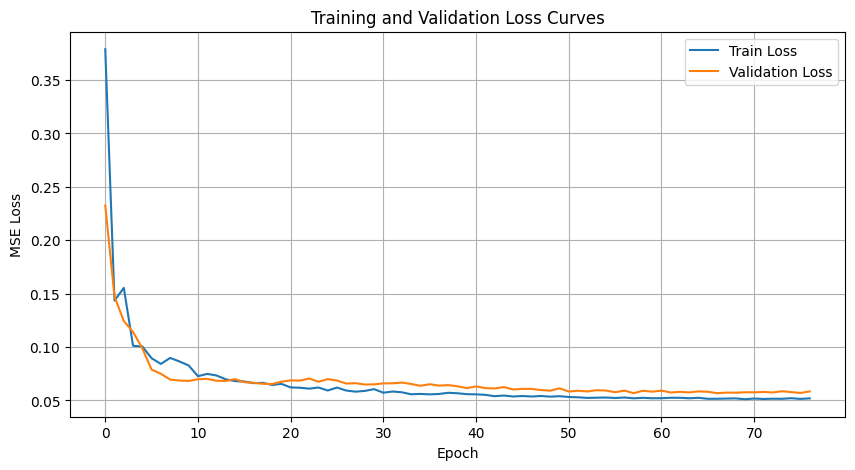

In [10]:
# ----------------------------------------
# 9. Training the Best Model
# ----------------------------------------

# Extract best hyperparameters
best_hidden_channels = best_trial.params['hidden_channels']
best_latent_dim = best_trial.params['latent_dim']
best_decoder_channels = best_trial.params['decoder_channels']
best_dropout = best_trial.params['dropout']
best_lr = best_trial.params['lr']
best_weight_decay = best_trial.params['weight_decay']

# Initialize Best Model
best_model = GNN_VAE(
    input_dim=x.size(1),
    hidden_channels=best_hidden_channels,
    latent_dim=best_latent_dim,
    decoder_channels=best_decoder_channels,
    num_tags=num_tags,
    dropout=best_dropout
)
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)  

# Train Best Model with Extended Epochs
print("\nTraining the Best Model...")
best_history = train_model(
    best_model, data, train_idx, val_idx, edge_weight, tag_indices_tensor, 
    optimizer, scheduler, epochs=100, early_stopping_patience=10
)

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(best_history['train_loss'], label='Train Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# ----------------------------------------
# 10. Final Evaluation on Test Set
# ----------------------------------------

print("\nEvaluating on Test Set...")
test_loss, test_precision, test_ndcg = evaluate_model(
    best_model, data, test_idx, edge_weight, tag_indices_tensor 
)


Evaluating on Test Set...
Test Loss: 0.0580, Precision@10: 0.8000, NDCG@10: 0.7668


In [12]:
# ----------------------------------------
# 11. Saving the Model and Results
# ----------------------------------------

# Save the best model
torch.save(best_model.state_dict(), "best_gnn_vae_model1.pth")
print("\nBest model saved as 'best_gnn_vae_model1.pth'.")

# Save training history
with open("training_history.json", "w") as f:
    json.dump(best_history, f)
print("Training history saved as 'training_history.json'.")

# Save Optuna study
joblib.dump(study, "optuna_study1.pkl")
print("Optuna study saved as 'optuna_study.pkl1'.")


Best model saved as 'best_gnn_vae_model1.pth'.
Training history saved as 'training_history.json'.
Optuna study saved as 'optuna_study.pkl1'.


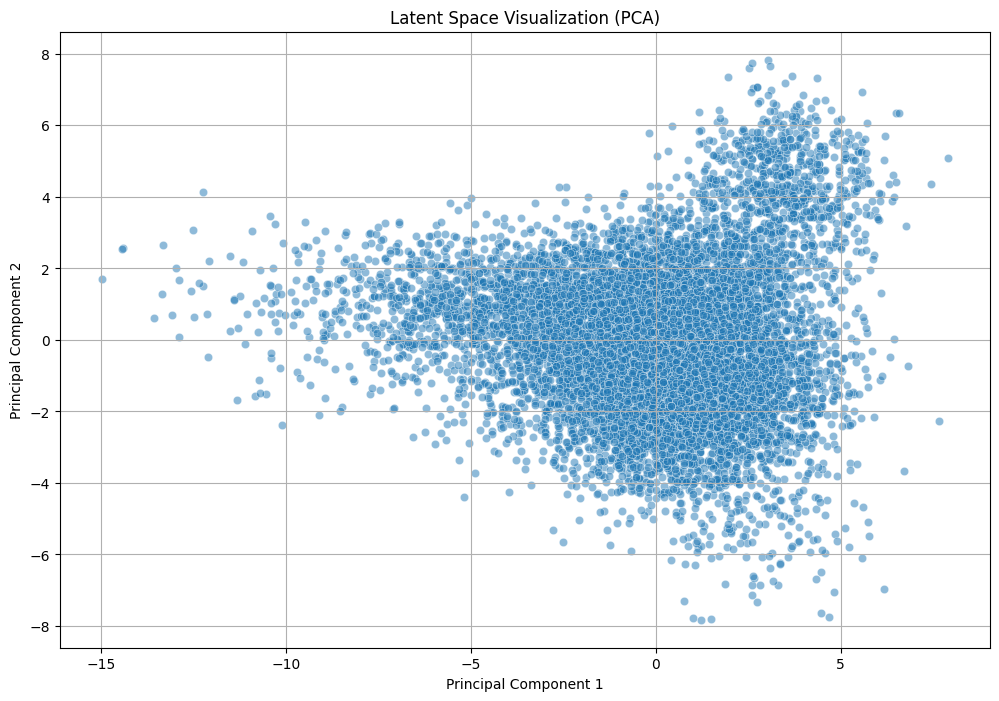

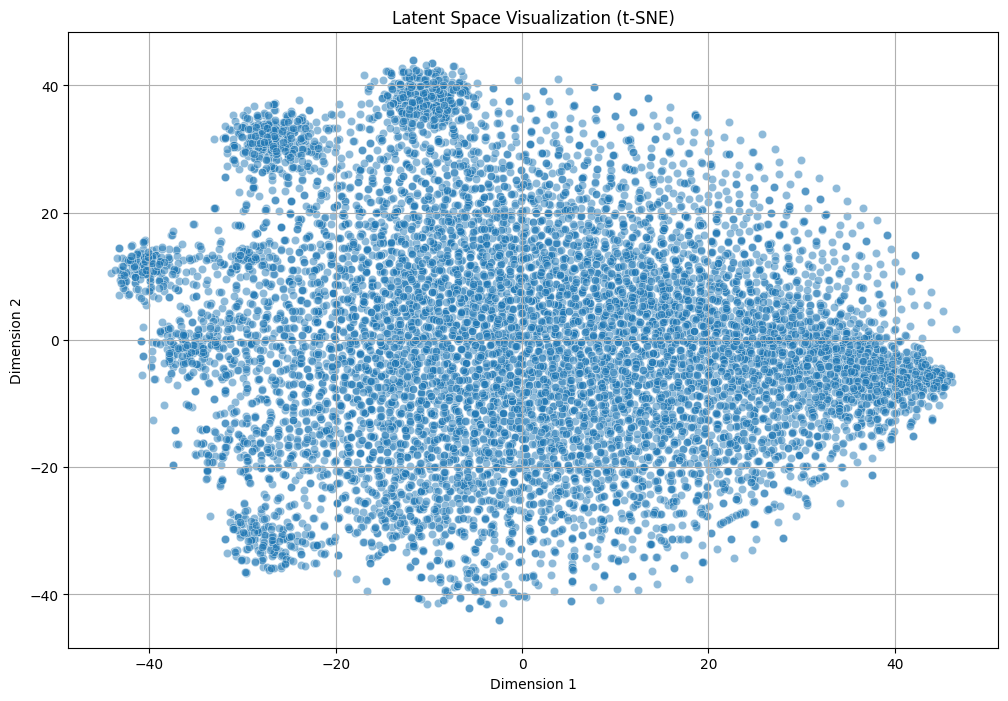

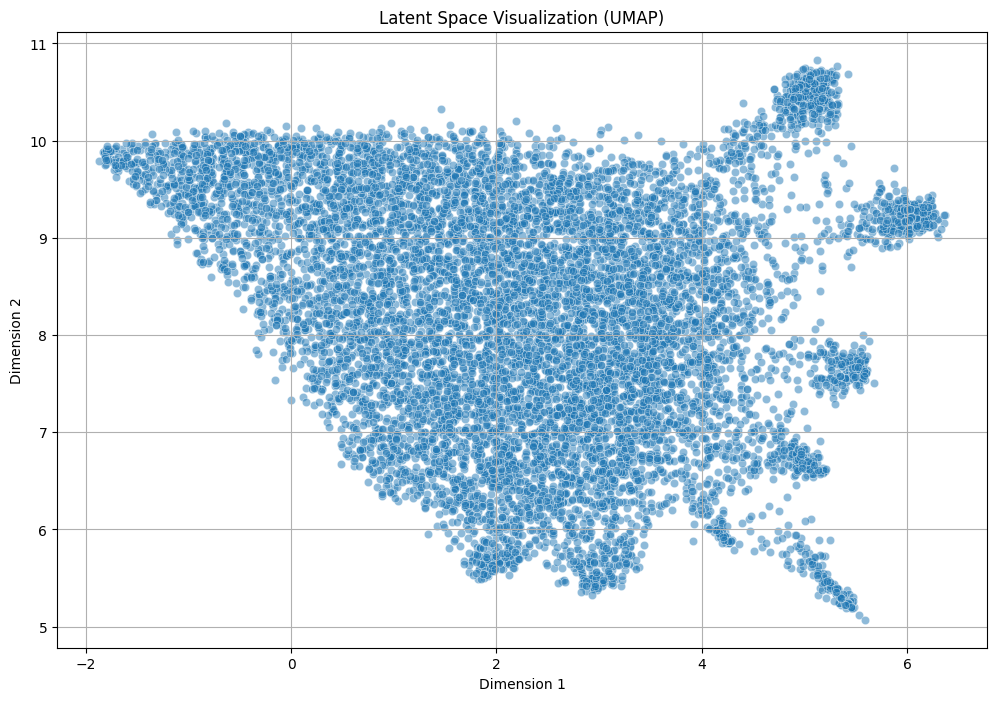

In [15]:
# ----------------------------------------
# 12. Additional Enhancements
# ----------------------------------------

# Visualization of Latent Space (e.g., using PCA or t-SNE)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE  # UPDATED for t-SNE
import seaborn as sns

def visualize_latent_space(model, data):
    model.eval()
    with torch.no_grad():
        mu, logvar = model.encode(data.x, data.edge_index)
        z = model.reparameterize(mu, logvar).cpu().numpy()
    
    # Reduce dimensions for visualization using PCA
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z)
    
    # Plot PCA
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=z_pca[:,0], y=z_pca[:,1], alpha=0.5)
    plt.title('Latent Space Visualization (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()
    
    # Additional: t-SNE Visualization 
    tsne = TSNE(n_components=2, random_state=42)
    z_tsne = tsne.fit_transform(z)
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=z_tsne[:,0], y=z_tsne[:,1], alpha=0.5)
    plt.title('Latent Space Visualization (t-SNE)')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()
    
    # You can also add UMAP if desired
    try:
        import umap
        umap_reducer = umap.UMAP(n_components=2, random_state=42)
        z_umap = umap_reducer.fit_transform(z)
        
        plt.figure(figsize=(12, 8))
        sns.scatterplot(x=z_umap[:,0], y=z_umap[:,1], alpha=0.5)
        plt.title('Latent Space Visualization (UMAP)')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.grid(True)
        plt.show()
    except ImportError:
        print("UMAP is not installed. Skipping UMAP visualization.")

visualize_latent_space(best_model, data)